# Analysis of two-locus sweep-with-gene-conversion simulation outcomes
This notebook reads in the results of our SLiM simulations and then calculates the fraction of pseudo-soft sweeps and other related outcomes for each parameter combination for each simulation model.
 
First, we define a function to read in the data generated by the `parseOutputForSpecies.py` script at the end of the pipeline described in this repository's README, and calculate the mean value of our target simulation outcomes across all replicates for a given parameter combination (each of which has its own summary file generated by `parseOutputForSpecies.py`.

Note: if you did not write out all of your simulation results to the default directories in this pipeline (i.e. if you changed what I had hard-coded into the python scripts), then you will have to change initialization line for `summaryOutDir` below to have it point to where you wrote the output from the `parseOutputForSpecies.py` step.

In [1]:
import os
import numpy as np
import scipy.stats

summaryOutDir = "slimResultSummaries/"

def parseSummaryResults(summaryFileName):
    totalReps, goodReps, fixedCount, partialCount, sweepingMutAbsentFromSamp = 0, 0, 0, 0, 0
    fixedSoftCount, fixedSoftCount, fixedSoftSampCount, partialSoftSampCount = 0, 0, 0, 0
    m3FreqsPop, m3FreqsSamp, m3PartialFreqs, partialSweepFreqs, sojournTimes, restartCounts = [], [], [], [], [], []
    #print(summaryFileName)
    with open(summaryFileName, 'rt') as sf:
        for line in sf:
            #print(line)
            repNum, isGoodRep, isFixed, isFixedSoftPop, m3freqPop, isFixedSoftSamp, m3CountSamp, n, isPartialSoftSamp, \
            m3PartialCountSamp, m3PartialDenomSamp, sojournTime, restartCount = line.strip().split()
            if isGoodRep == "1":
                goodReps += 1
                restartCounts.append(int(restartCount))
                if isFixed == "1":
                    sojournTimes.append(int(sojournTime))
                    
                    if int(isFixedSoftPop):
                        m3FreqsPop.append(float(m3freqPop))
                    if int(isFixedSoftSamp):
                        m3Freq = int(m3CountSamp)/int(n)
                        m3FreqsSamp.append(m3Freq)
                    fixedCount += 1
                    fixedSoftCount += int(isFixedSoftPop)
                    fixedSoftSampCount += int(isFixedSoftSamp)
                else:
                    m3PartialCountSamp, m3PartialDenomSamp = int(m3PartialCountSamp), int(m3PartialDenomSamp)
                    if m3PartialDenomSamp == 0:
                        sweepingMutAbsentFromSamp += 1
                    else:
                        partialCount += 1
                        if int(isPartialSoftSamp):
                            m3PartialFreq = m3PartialCountSamp/m3PartialDenomSamp
                            m3PartialFreqs.append(m3PartialFreq)
                            partialSoftSampCount += 1
                    partialSweepFreqs.append(m3PartialDenomSamp / int(n))
            totalReps += 1
                        
    goodRepFrac = goodReps/totalReps
    if partialCount == 0:
        partialSoftSampFrac = "NA"
    else:
        partialSoftSampFrac = partialSoftSampCount / partialCount
    if fixedCount == 0:
        fixedSoftFrac = "NA"
        fixedSoftSampFrac = "NA"
    else:
        fixedSoftFrac = fixedSoftCount / fixedCount
        fixedSoftSampFrac = fixedSoftSampCount / fixedCount
    
    popMean = np.mean(m3FreqsPop) if m3FreqsPop else "NA"
    sampMean = np.mean(m3FreqsSamp) if m3FreqsSamp else "NA"
    partialMean = np.mean(m3PartialFreqs) if m3PartialFreqs else "NA"
    totalSampMean = np.mean(m3FreqsSamp+m3PartialFreqs) if m3FreqsSamp+m3PartialFreqs else "NA"
    sampMeanSEM = scipy.stats.sem(m3FreqsSamp+m3PartialFreqs) if m3FreqsSamp+m3PartialFreqs else "NA"
    fixedFrac = fixedCount/goodReps if goodReps else "NA"
    partialFrac = partialCount/goodReps if goodReps else "NA"
    partialSweepMean = np.mean(partialSweepFreqs) if partialSweepFreqs else "NA"
    sweepingMutAbsentFromSampFrac = sweepingMutAbsentFromSamp/goodReps if goodReps else "NA"
    meanSojournTime = np.mean(sojournTimes) if sojournTimes else "NA"
    meanRestartCount = np.mean(restartCounts) if restartCounts else "NA"
        
    return (goodRepFrac, fixedFrac, partialFrac, sweepingMutAbsentFromSampFrac, popMean, fixedSoftFrac, sampMean, fixedSoftSampFrac,\
            partialMean, totalSampMean, sampMeanSEM, partialSoftSampFrac, partialSweepMean, meanSojournTime, meanRestartCount)   

With that function ready to rock, we can now read in the simulation outcome summary file for each parameter combination. For each demographic model simulated for each species, we create a `pandas` dataframe that we will use to generate our final figures. We show these tables below, and they are pretty big, so you have to scroll way down to get to our next piece of code where we get to the plotting.

In [2]:
import pandas as pd

columns = "Selection Coefficient,Dominance Coefficient,Sweep Start Time,Gene Conversion Ratio"
columns += ",Good Rep %,Fixed %,Partial %,Sweeping mut absent from samp%,Mean Recombinant Pop Freq (fixed),Fraction Soft in Pop (fixed)"
columns += ",Mean Recombinant Sample Freq (fixed),Fraction Soft in Sample (fixed),Mean Recombinant Sample Freq (incomplete),Mean Rec Sample Freq (all)"
columns += ",SEM Rec Sample Freq (all),Fraction Soft in Sample (incomplete),Mean Sweep Freq in Sample (incomplete),Mean Sojourn Time,Mean Restart Count"
columns = columns.split(",")

allResults = {}
for fName in os.listdir(summaryOutDir):
    specName, demogModel, mapName, contigName, targetPop, popNumber, sampleSize, Q, selCoeff, domCoeff, selTime, \
    geneConvRatio = fName.rstrip(".txt").split("-")

    results = [float(selCoeff), float(domCoeff), float(selTime), float(geneConvRatio)]
    results += parseSummaryResults(summaryOutDir + "/" + fName)
    if not (specName,demogModel,targetPop) in allResults:
        allResults[(specName,demogModel,targetPop)] = []
    allResults[(specName,demogModel,targetPop)].append(results)

pd.options.display.max_rows = 999
tables = {}
for specName, demogModel, targetPop in sorted(allResults):
    print(specName, demogModel, targetPop)
    table = pd.DataFrame(allResults[(specName,demogModel,targetPop)], columns=columns)
    tables[(specName, demogModel, targetPop)] = table
    display(table.sort_values(
        by = ['Gene Conversion Ratio', 'Sweep Start Time', 'Selection Coefficient', 'Dominance Coefficient'],
        ascending = [True, True, True, True]).fillna("NA"))

/nas/longleaf/rhel8/apps/anaconda/2021.11.ood/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/nas/longleaf/rhel8/apps/anaconda/2021.11.ood/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AraTha African3Epoch_1H18 SouthMiddleAtlas


Selection Coefficient  Dominance Coefficient  Sweep Start Time  \
0                    0.001                    0.0              0.01   
25                   0.001                    0.5              0.01   
50                   0.001                    1.0              0.01   
75                   0.010                    0.0              0.01   
100                  0.010                    0.5              0.01   
125                  0.010                    1.0              0.01   
150                  0.100                    0.0              0.01   
175                  0.100                    0.5              0.01   
200                  0.100                    1.0              0.01   
5                    0.001                    0.0              0.05   
30                   0.001                    0.5              0.05   
55                   0.001                    1.0              0.05   
80                   0.010                    0.0              0.05   
105                  0.010                    0.5              0.05   
130                  0.010                    1.0              0.05   
155                  0.100                    0.0              0.05   
180                  0.100                    0.5              0.05   
205                  0.100                    1.0              0.05   
10                   0.001                    0.0              0.10   
35                   0.001                    0.5              0.10   
60                   0.001                    1.0              0.10   
85                   0.010                    0.0              0.10   
110                  0.010                    0.5              0.10   
135                  0.010                    1.0              0.10   
160                  0.100                    0.0              0.10   
185                  0.100                    0.5              0.10   
210                  0.100                    1.0              0.10   
15                   0.001                    0.0              0.50   
40                   0.001                    0.5              0.50   
65                   0.001                    1.0              0.50   
90                   0.010                    0.0              0.50   
115                  0.010                    0.5              0.50   
140                  0.010                    1.0              0.50   
165                  0.100                    0.0              0.50   
190                  0.100                    0.5              0.50   
215                  0.100                    1.0              0.50   
20                   0.001                    0.0              1.00   
45                   0.001                    0.5              1.00   
70                   0.001                    1.0              1.00   
95                   0.010                    0.0              1.00   
120                  0.010                    0.5              1.00   
145                  0.010                    1.0              1.00   
170                  0.100                    0.0              1.00   
195                  0.100                    0.5              1.00   
220                  0.100                    1.0              1.00   
1                    0.001                    0.0              0.01   
26                   0.001                    0.5              0.01   
51                   0.001                    1.0              0.01   
76                   0.010                    0.0              0.01   
101                  0.010                    0.5              0.01   
126                  0.010                    1.0              0.01   
151                  0.100                    0.0              0.01   
176                  0.100                    0.5              0.01   
201                  0.100                    1.0              0.01   
6                    0.001                    0.0              0.05   
31                   0.001   

AraTha const1pop 0


Selection Coefficient  Dominance Coefficient  Sweep Start Time  \
0                    0.001                    0.0              0.01   
25                   0.001                    0.5              0.01   
50                   0.001                    1.0              0.01   
75                   0.010                    0.0              0.01   
100                  0.010                    0.5              0.01   
125                  0.010                    1.0              0.01   
150                  0.100                    0.0              0.01   
175                  0.100                    0.5              0.01   
200                  0.100                    1.0              0.01   
5                    0.001                    0.0              0.05   
30                   0.001                    0.5              0.05   
55                   0.001                    1.0              0.05   
80                   0.010                    0.0              0.05   
105                  0.010                    0.5              0.05   
130                  0.010                    1.0              0.05   
155                  0.100                    0.0              0.05   
180                  0.100                    0.5              0.05   
205                  0.100                    1.0              0.05   
10                   0.001                    0.0              0.10   
35                   0.001                    0.5              0.10   
60                   0.001                    1.0              0.10   
85                   0.010                    0.0              0.10   
110                  0.010                    0.5              0.10   
135                  0.010                    1.0              0.10   
160                  0.100                    0.0              0.10   
185                  0.100                    0.5              0.10   
210                  0.100                    1.0              0.10   
15                   0.001                    0.0              0.50   
40                   0.001                    0.5              0.50   
65                   0.001                    1.0              0.50   
90                   0.010                    0.0              0.50   
115                  0.010                    0.5              0.50   
140                  0.010                    1.0              0.50   
165                  0.100                    0.0              0.50   
190                  0.100                    0.5              0.50   
215                  0.100                    1.0              0.50   
20                   0.001                    0.0              1.00   
45                   0.001                    0.5              1.00   
70                   0.001                    1.0              1.00   
95                   0.010                    0.0              1.00   
120                  0.010                    0.5              1.00   
145                  0.010                    1.0              1.00   
170                  0.100                    0.0              1.00   
195                  0.100                    0.5              1.00   
220                  0.100                    1.0              1.00   
1                    0.001                    0.0              0.01   
26                   0.001                    0.5              0.01   
51                   0.001                    1.0              0.01   
76                   0.010                    0.0              0.01   
101                  0.010                    0.5              0.01   
126                  0.010                    1.0              0.01   
151                  0.100                    0.0              0.01   
176                  0.100                    0.5              0.01   
201                  0.100                    1.0              0.01   
6                    0.001                    0.0              0.05   
31                   0.001   

DroMel African3Epoch_1S16 AFR


Selection Coefficient  Dominance Coefficient  Sweep Start Time  \
0                    0.001                    0.0              0.01   
25                   0.001                    0.5              0.01   
50                   0.001                    1.0              0.01   
75                   0.010                    0.0              0.01   
100                  0.010                    0.5              0.01   
125                  0.010                    1.0              0.01   
150                  0.100                    0.0              0.01   
175                  0.100                    0.5              0.01   
200                  0.100                    1.0              0.01   
5                    0.001                    0.0              0.05   
30                   0.001                    0.5              0.05   
55                   0.001                    1.0              0.05   
80                   0.010                    0.0              0.05   
105                  0.010                    0.5              0.05   
130                  0.010                    1.0              0.05   
155                  0.100                    0.0              0.05   
180                  0.100                    0.5              0.05   
205                  0.100                    1.0              0.05   
10                   0.001                    0.0              0.10   
35                   0.001                    0.5              0.10   
60                   0.001                    1.0              0.10   
85                   0.010                    0.0              0.10   
110                  0.010                    0.5              0.10   
135                  0.010                    1.0              0.10   
160                  0.100                    0.0              0.10   
185                  0.100                    0.5              0.10   
210                  0.100                    1.0              0.10   
15                   0.001                    0.0              0.50   
40                   0.001                    0.5              0.50   
65                   0.001                    1.0              0.50   
90                   0.010                    0.0              0.50   
115                  0.010                    0.5              0.50   
140                  0.010                    1.0              0.50   
165                  0.100                    0.0              0.50   
190                  0.100                    0.5              0.50   
215                  0.100                    1.0              0.50   
20                   0.001                    0.0              1.00   
45                   0.001                    0.5              1.00   
70                   0.001                    1.0              1.00   
95                   0.010                    0.0              1.00   
120                  0.010                    0.5              1.00   
145                  0.010                    1.0              1.00   
170                  0.100                    0.0              1.00   
195                  0.100                    0.5              1.00   
220                  0.100                    1.0              1.00   
1                    0.001                    0.0              0.01   
26                   0.001                    0.5              0.01   
51                   0.001                    1.0              0.01   
76                   0.010                    0.0              0.01   
101                  0.010                    0.5              0.01   
126                  0.010                    1.0              0.01   
151                  0.100                    0.0              0.01   
176                  0.100                    0.5              0.01   
201                  0.100                    1.0              0.01   
6                    0.001                    0.0              0.05   
31                   0.001   

DroMel const1pop 0


Selection Coefficient  Dominance Coefficient  Sweep Start Time  \
0                    0.001                    0.0              0.01   
25                   0.001                    0.5              0.01   
50                   0.001                    1.0              0.01   
75                   0.010                    0.0              0.01   
100                  0.010                    0.5              0.01   
125                  0.010                    1.0              0.01   
150                  0.100                    0.0              0.01   
175                  0.100                    0.5              0.01   
200                  0.100                    1.0              0.01   
5                    0.001                    0.0              0.05   
30                   0.001                    0.5              0.05   
55                   0.001                    1.0              0.05   
80                   0.010                    0.0              0.05   
105                  0.010                    0.5              0.05   
130                  0.010                    1.0              0.05   
155                  0.100                    0.0              0.05   
180                  0.100                    0.5              0.05   
205                  0.100                    1.0              0.05   
10                   0.001                    0.0              0.10   
35                   0.001                    0.5              0.10   
60                   0.001                    1.0              0.10   
85                   0.010                    0.0              0.10   
110                  0.010                    0.5              0.10   
135                  0.010                    1.0              0.10   
160                  0.100                    0.0              0.10   
185                  0.100                    0.5              0.10   
210                  0.100                    1.0              0.10   
15                   0.001                    0.0              0.50   
40                   0.001                    0.5              0.50   
65                   0.001                    1.0              0.50   
90                   0.010                    0.0              0.50   
115                  0.010                    0.5              0.50   
140                  0.010                    1.0              0.50   
165                  0.100                    0.0              0.50   
190                  0.100                    0.5              0.50   
215                  0.100                    1.0              0.50   
20                   0.001                    0.0              1.00   
45                   0.001                    0.5              1.00   
70                   0.001                    1.0              1.00   
95                   0.010                    0.0              1.00   
120                  0.010                    0.5              1.00   
145                  0.010                    1.0              1.00   
170                  0.100                    0.0              1.00   
195                  0.100                    0.5              1.00   
220                  0.100                    1.0              1.00   
1                    0.001                    0.0              0.01   
26                   0.001                    0.5              0.01   
51                   0.001                    1.0              0.01   
76                   0.010                    0.0              0.01   
101                  0.010                    0.5              0.01   
126                  0.010                    1.0              0.01   
151                  0.100                    0.0              0.01   
176                  0.100                    0.5              0.01   
201                  0.100                    1.0              0.01   
6                    0.001                    0.0              0.05   
31                   0.001   

HomSap OutOfAfrica_2T12 AFR


Selection Coefficient  Dominance Coefficient  Sweep Start Time  \
0                    0.001                    0.0              0.01   
25                   0.001                    0.5              0.01   
50                   0.001                    1.0              0.01   
75                   0.010                    0.0              0.01   
100                  0.010                    0.5              0.01   
125                  0.010                    1.0              0.01   
150                  0.100                    0.0              0.01   
175                  0.100                    0.5              0.01   
200                  0.100                    1.0              0.01   
5                    0.001                    0.0              0.05   
30                   0.001                    0.5              0.05   
55                   0.001                    1.0              0.05   
80                   0.010                    0.0              0.05   
105                  0.010                    0.5              0.05   
130                  0.010                    1.0              0.05   
155                  0.100                    0.0              0.05   
180                  0.100                    0.5              0.05   
205                  0.100                    1.0              0.05   
10                   0.001                    0.0              0.10   
35                   0.001                    0.5              0.10   
60                   0.001                    1.0              0.10   
85                   0.010                    0.0              0.10   
110                  0.010                    0.5              0.10   
135                  0.010                    1.0              0.10   
160                  0.100                    0.0              0.10   
185                  0.100                    0.5              0.10   
210                  0.100                    1.0              0.10   
15                   0.001                    0.0              0.50   
40                   0.001                    0.5              0.50   
65                   0.001                    1.0              0.50   
90                   0.010                    0.0              0.50   
115                  0.010                    0.5              0.50   
140                  0.010                    1.0              0.50   
165                  0.100                    0.0              0.50   
190                  0.100                    0.5              0.50   
215                  0.100                    1.0              0.50   
20                   0.001                    0.0              1.00   
45                   0.001                    0.5              1.00   
70                   0.001                    1.0              1.00   
95                   0.010                    0.0              1.00   
120                  0.010                    0.5              1.00   
145                  0.010                    1.0              1.00   
170                  0.100                    0.0              1.00   
195                  0.100                    0.5              1.00   
220                  0.100                    1.0              1.00   
1                    0.001                    0.0              0.01   
26                   0.001                    0.5              0.01   
51                   0.001                    1.0              0.01   
76                   0.010                    0.0              0.01   
101                  0.010                    0.5              0.01   
126                  0.010                    1.0              0.01   
151                  0.100                    0.0              0.01   
176                  0.100                    0.5              0.01   
201                  0.100                    1.0              0.01   
6                    0.001                    0.0              0.05   
31                   0.001   

HomSap OutOfAfrica_2T12 EUR


Selection Coefficient  Dominance Coefficient  Sweep Start Time  \
0                    0.001                    0.0              0.01   
25                   0.001                    0.5              0.01   
50                   0.001                    1.0              0.01   
75                   0.010                    0.0              0.01   
100                  0.010                    0.5              0.01   
125                  0.010                    1.0              0.01   
150                  0.100                    0.0              0.01   
175                  0.100                    0.5              0.01   
200                  0.100                    1.0              0.01   
5                    0.001                    0.0              0.05   
30                   0.001                    0.5              0.05   
55                   0.001                    1.0              0.05   
80                   0.010                    0.0              0.05   
105                  0.010                    0.5              0.05   
130                  0.010                    1.0              0.05   
155                  0.100                    0.0              0.05   
180                  0.100                    0.5              0.05   
205                  0.100                    1.0              0.05   
10                   0.001                    0.0              0.10   
35                   0.001                    0.5              0.10   
60                   0.001                    1.0              0.10   
85                   0.010                    0.0              0.10   
110                  0.010                    0.5              0.10   
135                  0.010                    1.0              0.10   
160                  0.100                    0.0              0.10   
185                  0.100                    0.5              0.10   
210                  0.100                    1.0              0.10   
15                   0.001                    0.0              0.50   
40                   0.001                    0.5              0.50   
65                   0.001                    1.0              0.50   
90                   0.010                    0.0              0.50   
115                  0.010                    0.5              0.50   
140                  0.010                    1.0              0.50   
165                  0.100                    0.0              0.50   
190                  0.100                    0.5              0.50   
215                  0.100                    1.0              0.50   
20                   0.001                    0.0              1.00   
45                   0.001                    0.5              1.00   
70                   0.001                    1.0              1.00   
95                   0.010                    0.0              1.00   
120                  0.010                    0.5              1.00   
145                  0.010                    1.0              1.00   
170                  0.100                    0.0              1.00   
195                  0.100                    0.5              1.00   
220                  0.100                    1.0              1.00   
1                    0.001                    0.0              0.01   
26                   0.001                    0.5              0.01   
51                   0.001                    1.0              0.01   
76                   0.010                    0.0              0.01   
101                  0.010                    0.5              0.01   
126                  0.010                    1.0              0.01   
151                  0.100                    0.0              0.01   
176                  0.100                    0.5              0.01   
201                  0.100                    1.0              0.01   
6                    0.001                    0.0              0.05   
31                   0.001   

HomSap const1pop 0


Selection Coefficient  Dominance Coefficient  Sweep Start Time  \
0                    0.001                    0.0              0.01   
25                   0.001                    0.5              0.01   
50                   0.001                    1.0              0.01   
75                   0.010                    0.0              0.01   
100                  0.010                    0.5              0.01   
125                  0.010                    1.0              0.01   
150                  0.100                    0.0              0.01   
175                  0.100                    0.5              0.01   
200                  0.100                    1.0              0.01   
5                    0.001                    0.0              0.05   
30                   0.001                    0.5              0.05   
55                   0.001                    1.0              0.05   
80                   0.010                    0.0              0.05   
105                  0.010                    0.5              0.05   
130                  0.010                    1.0              0.05   
155                  0.100                    0.0              0.05   
180                  0.100                    0.5              0.05   
205                  0.100                    1.0              0.05   
10                   0.001                    0.0              0.10   
35                   0.001                    0.5              0.10   
60                   0.001                    1.0              0.10   
85                   0.010                    0.0              0.10   
110                  0.010                    0.5              0.10   
135                  0.010                    1.0              0.10   
160                  0.100                    0.0              0.10   
185                  0.100                    0.5              0.10   
210                  0.100                    1.0              0.10   
15                   0.001                    0.0              0.50   
40                   0.001                    0.5              0.50   
65                   0.001                    1.0              0.50   
90                   0.010                    0.0              0.50   
115                  0.010                    0.5              0.50   
140                  0.010                    1.0              0.50   
165                  0.100                    0.0              0.50   
190                  0.100                    0.5              0.50   
215                  0.100                    1.0              0.50   
20                   0.001                    0.0              1.00   
45                   0.001                    0.5              1.00   
70                   0.001                    1.0              1.00   
95                   0.010                    0.0              1.00   
120                  0.010                    0.5              1.00   
145                  0.010                    1.0              1.00   
170                  0.100                    0.0              1.00   
195                  0.100                    0.5              1.00   
220                  0.100                    1.0              1.00   
1                    0.001                    0.0              0.01   
26                   0.001                    0.5              0.01   
51                   0.001                    1.0              0.01   
76                   0.010                    0.0              0.01   
101                  0.010                    0.5              0.01   
126                  0.010                    1.0              0.01   
151                  0.100                    0.0              0.01   
176                  0.100                    0.5              0.01   
201                  0.100                    1.0              0.01   
6                    0.001                    0.0              0.05   
31                   0.001   

## How often does gene conversion produce pseudo-soft sweeps?
Now that we have read in our simulation outcomes and aggregated them for each parameter combination for demographic model, we can now visualize the results. The code below generates line plots do to this:

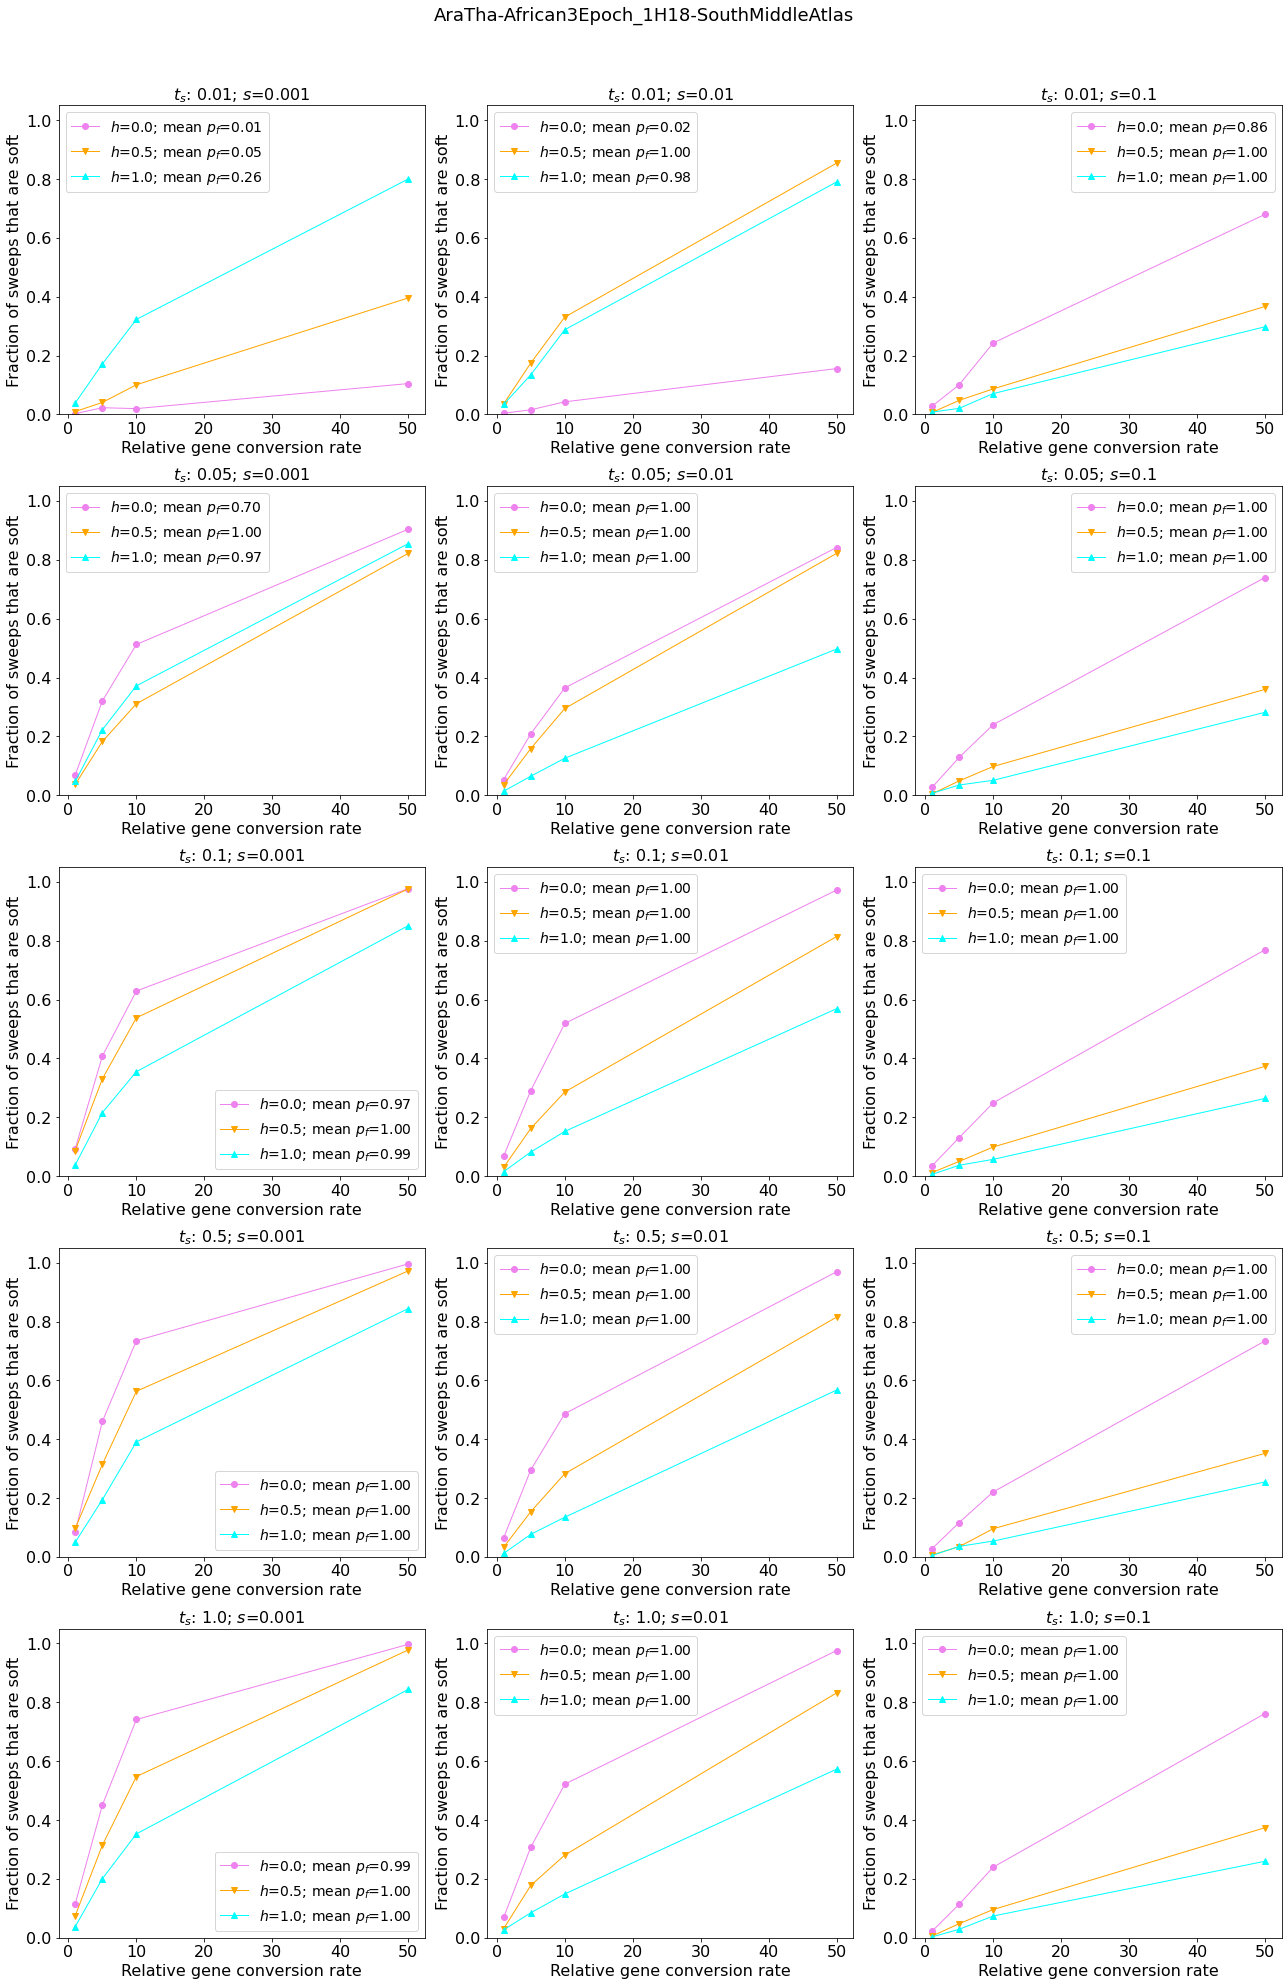

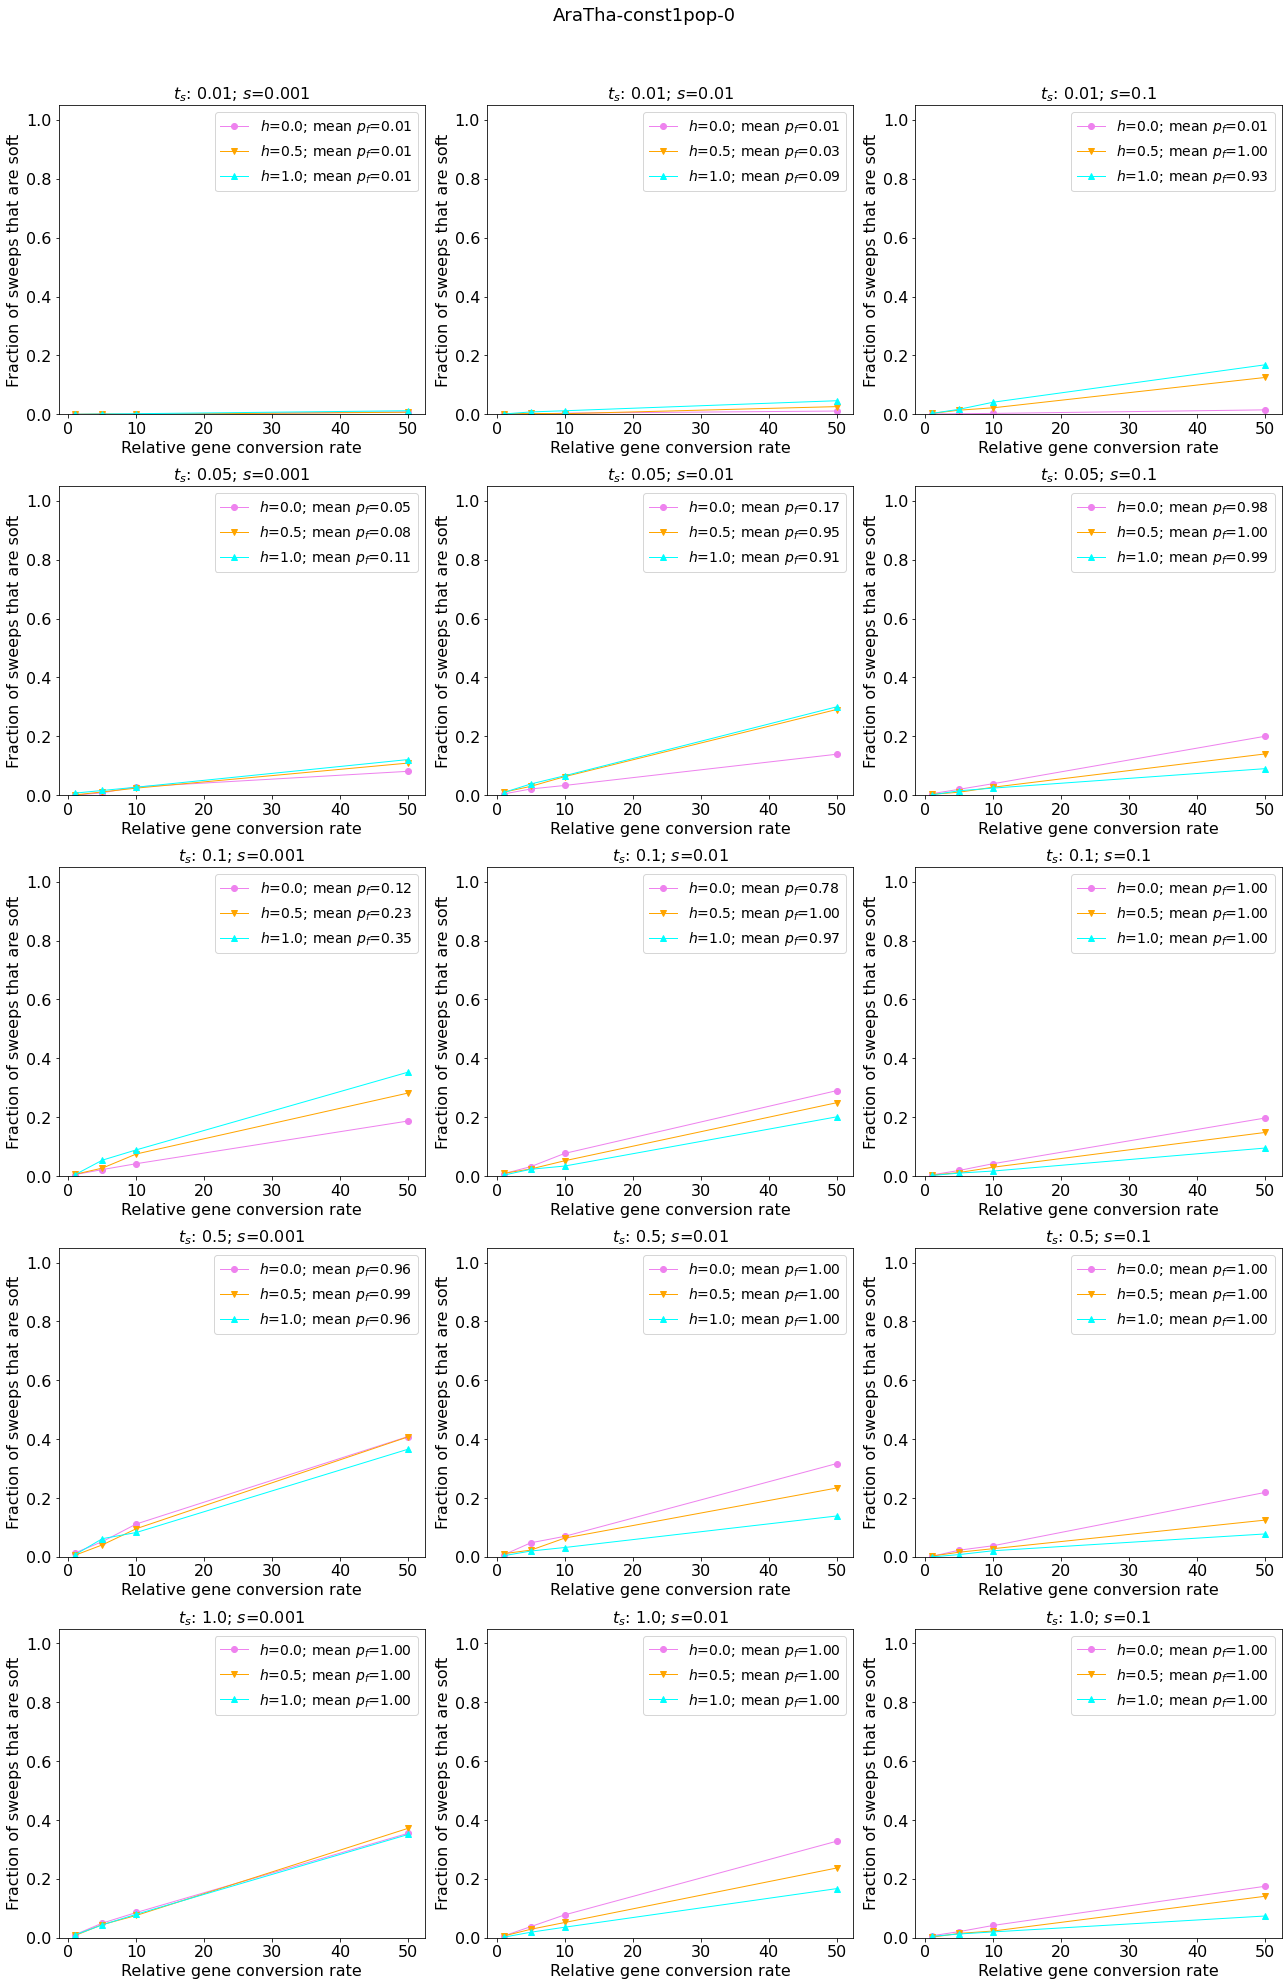

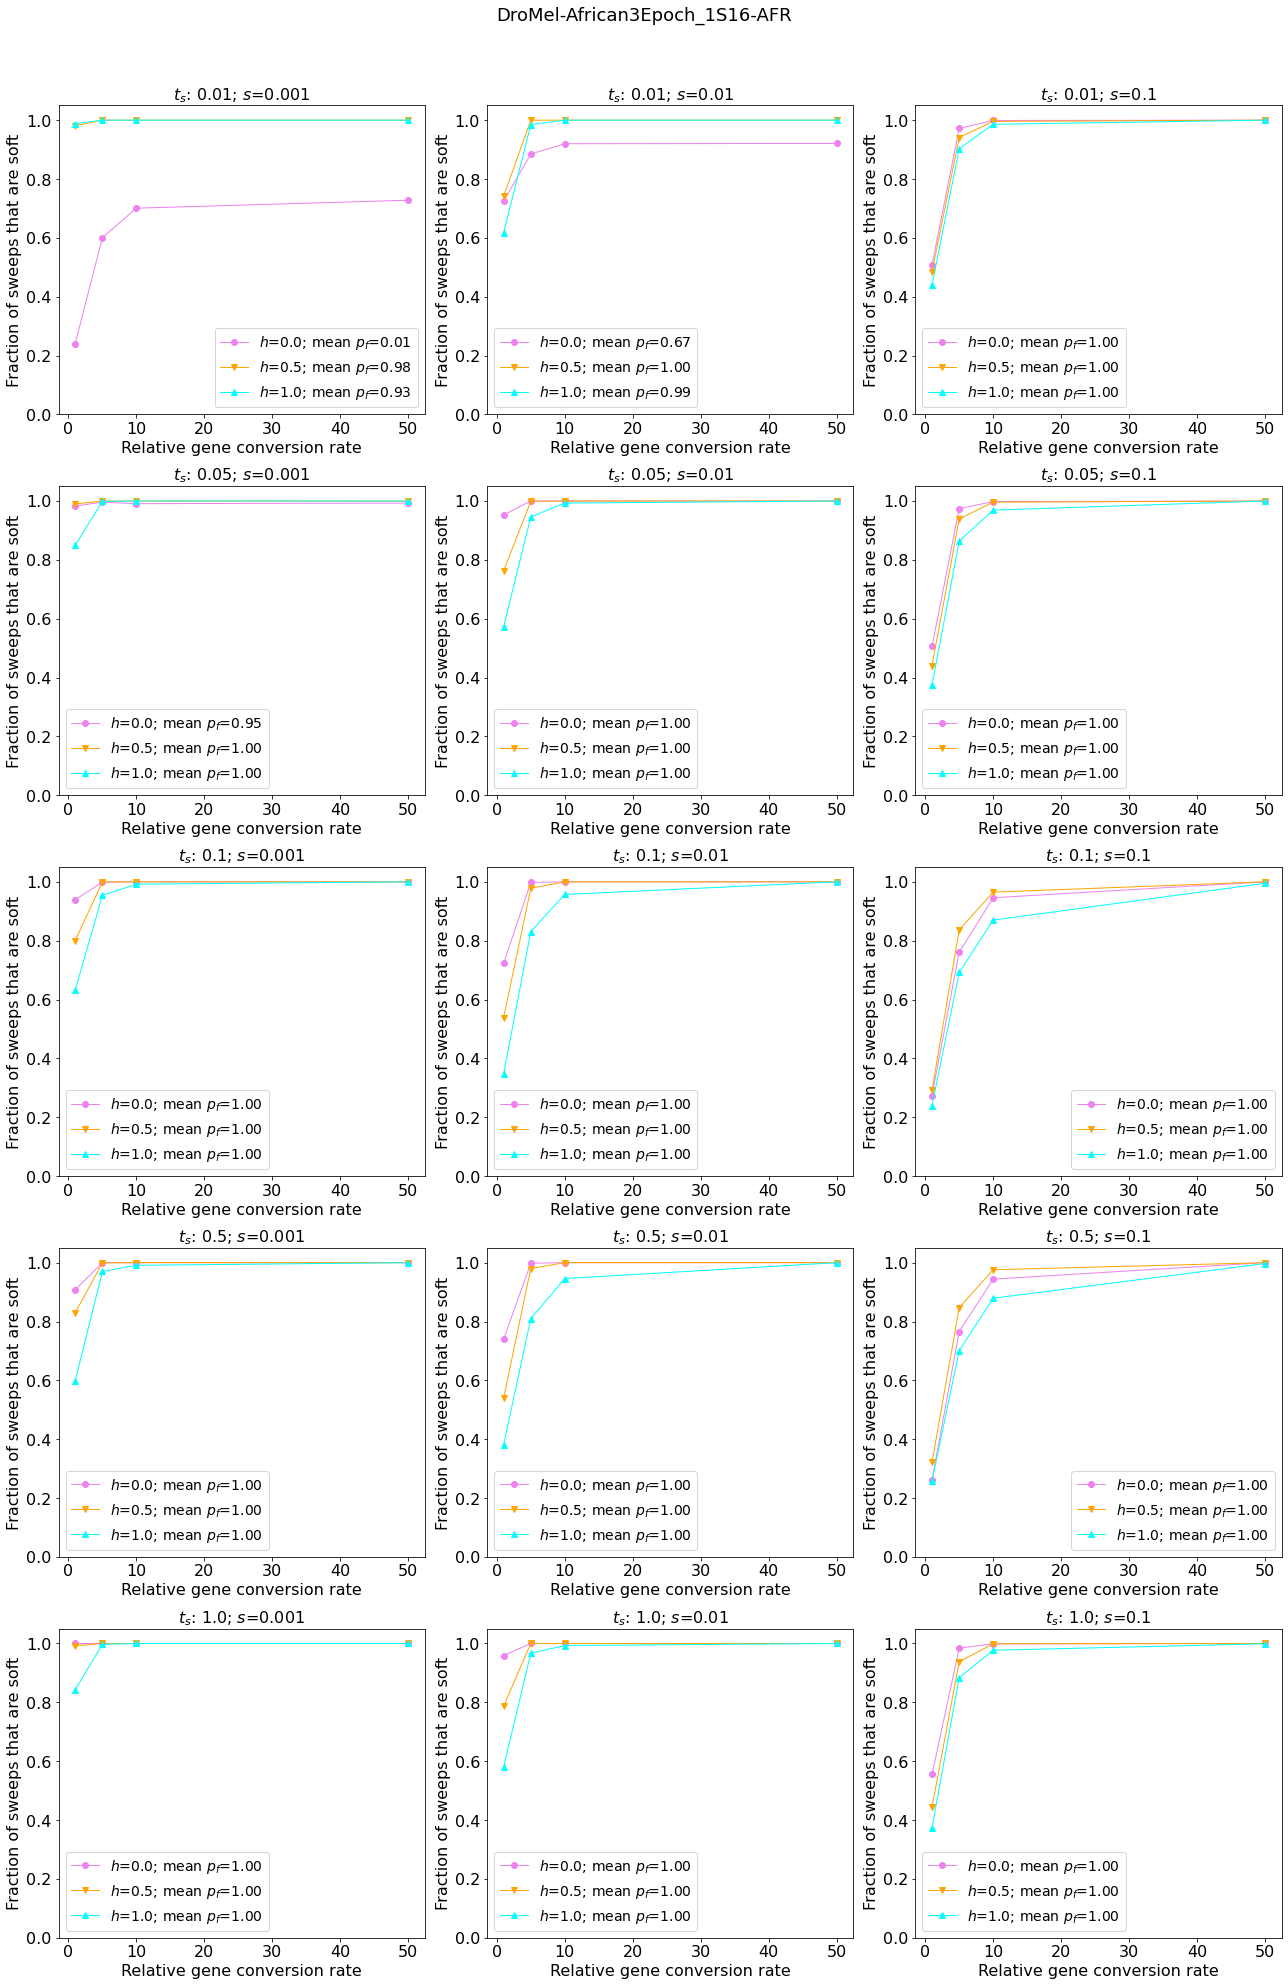

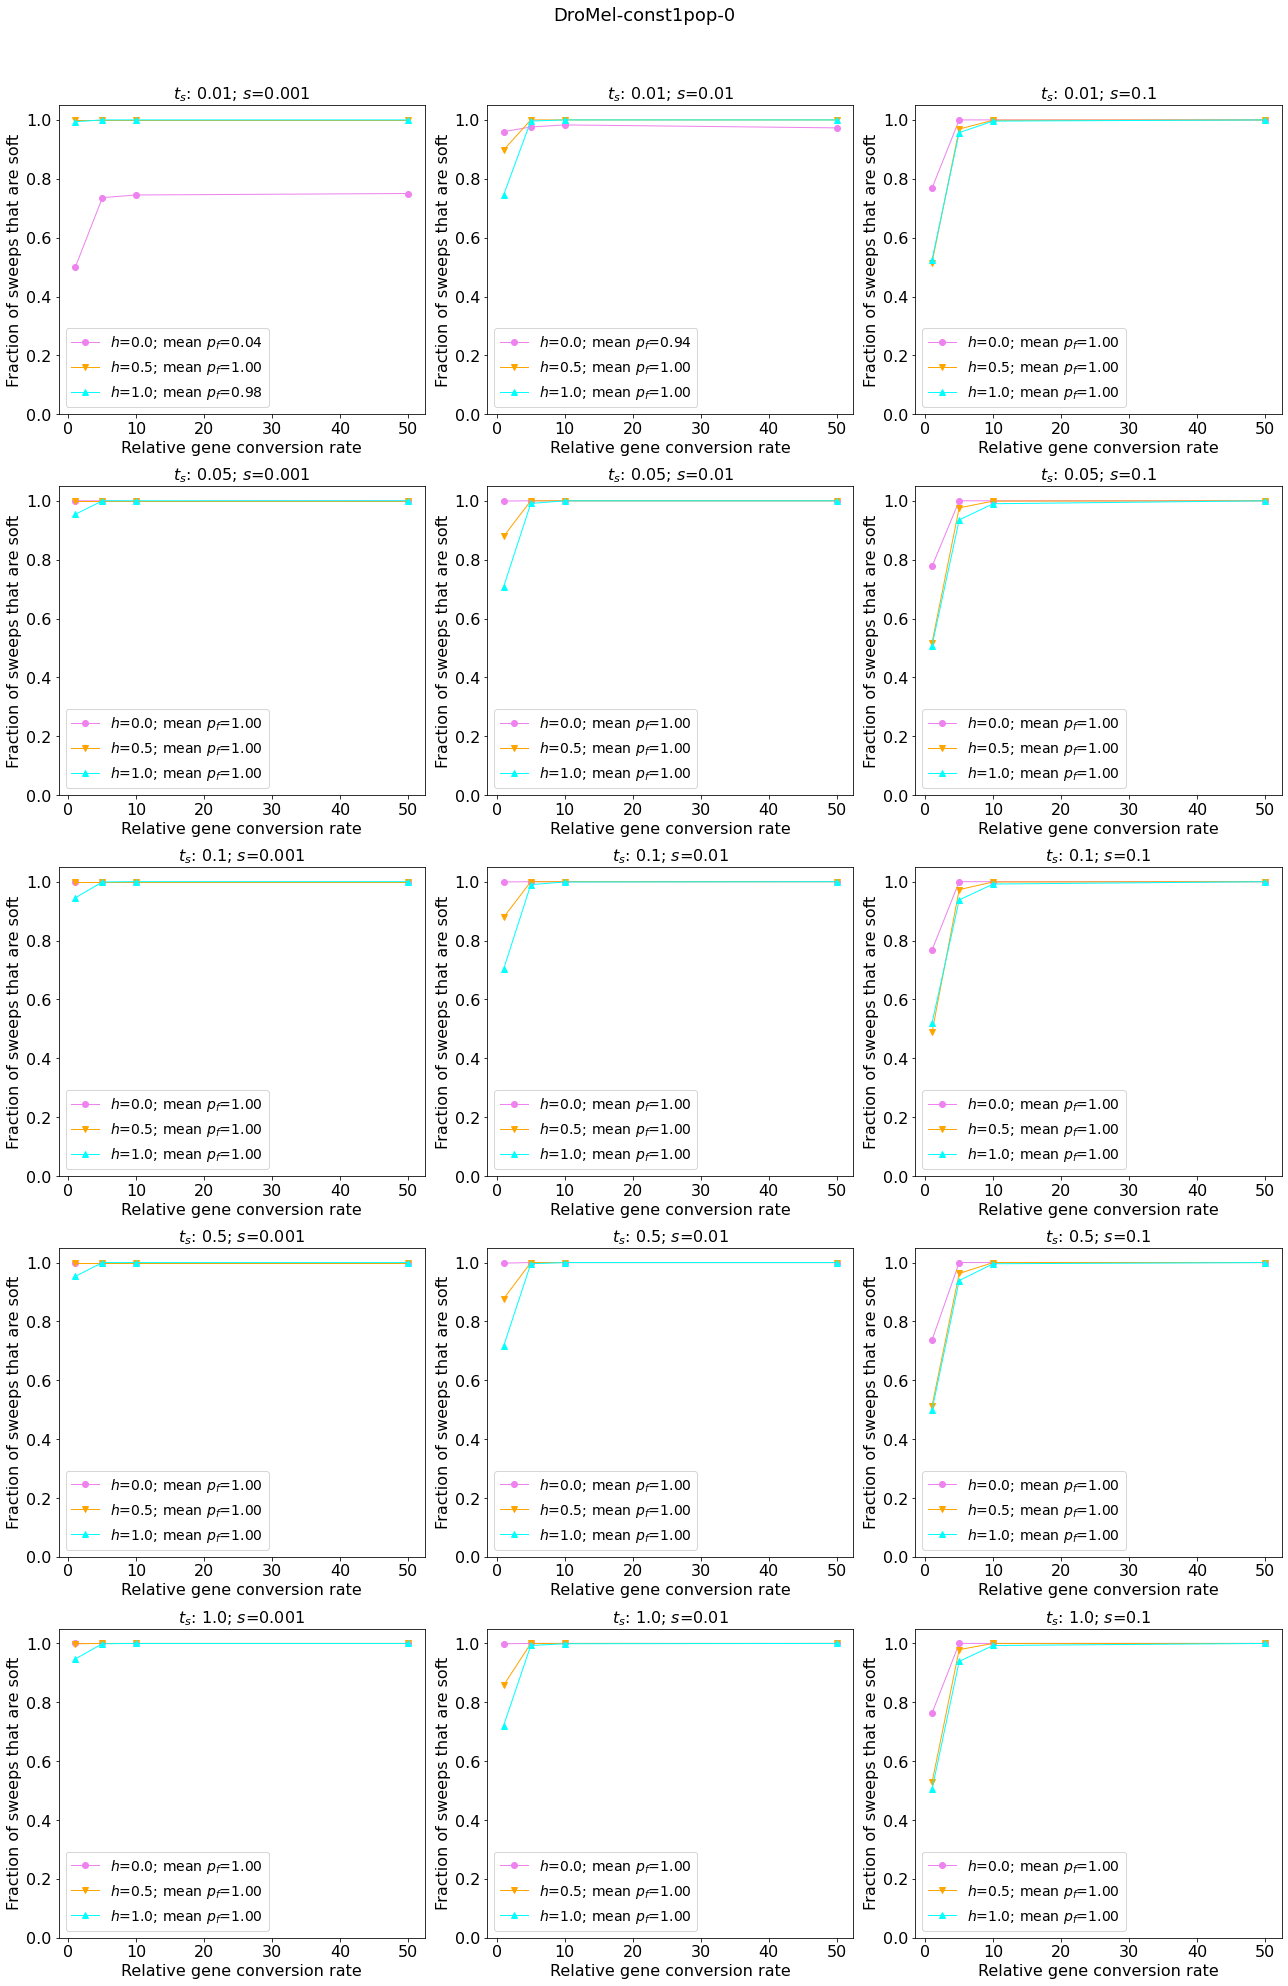

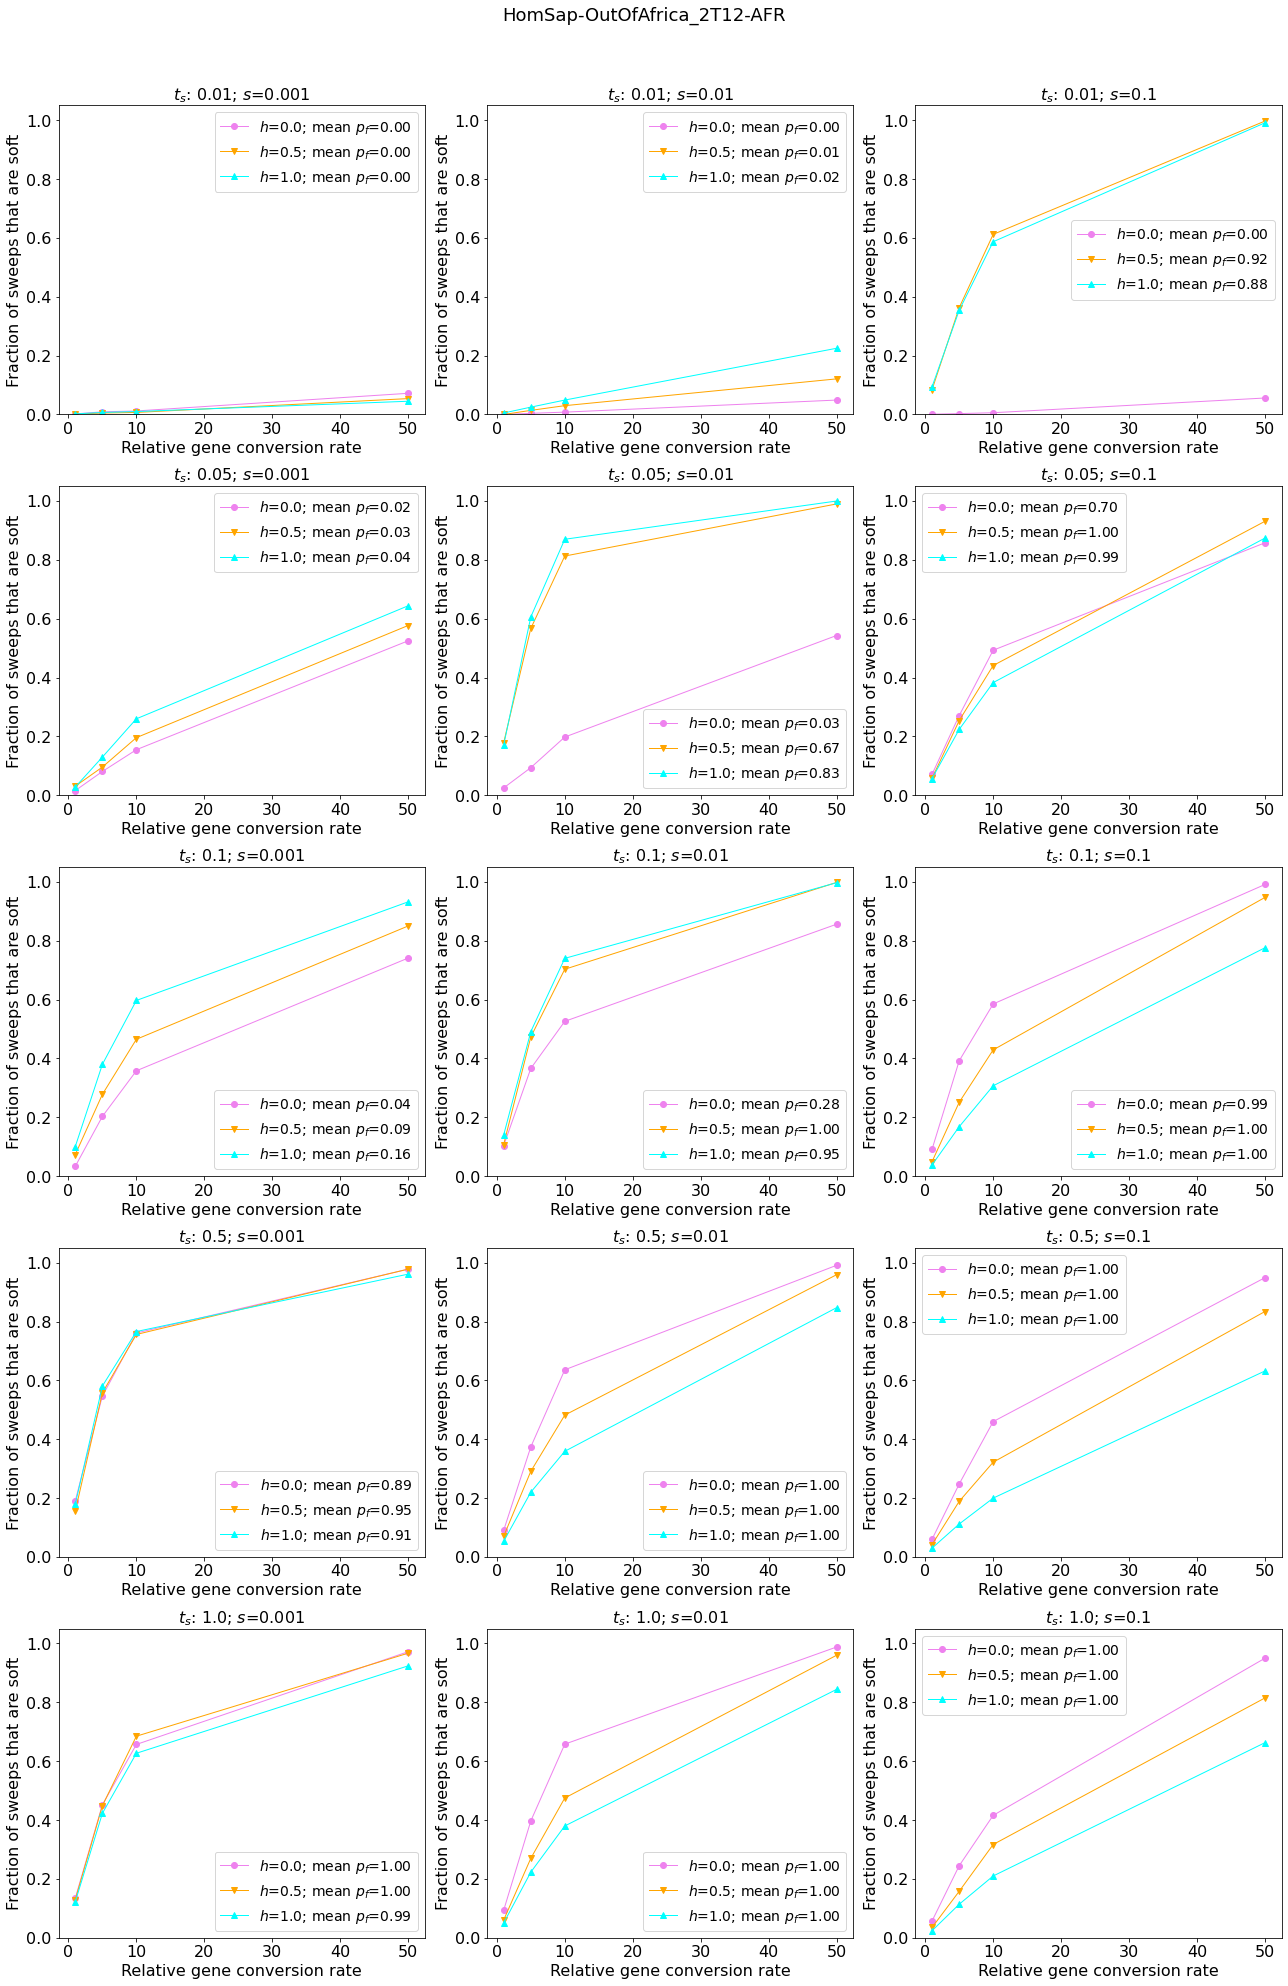

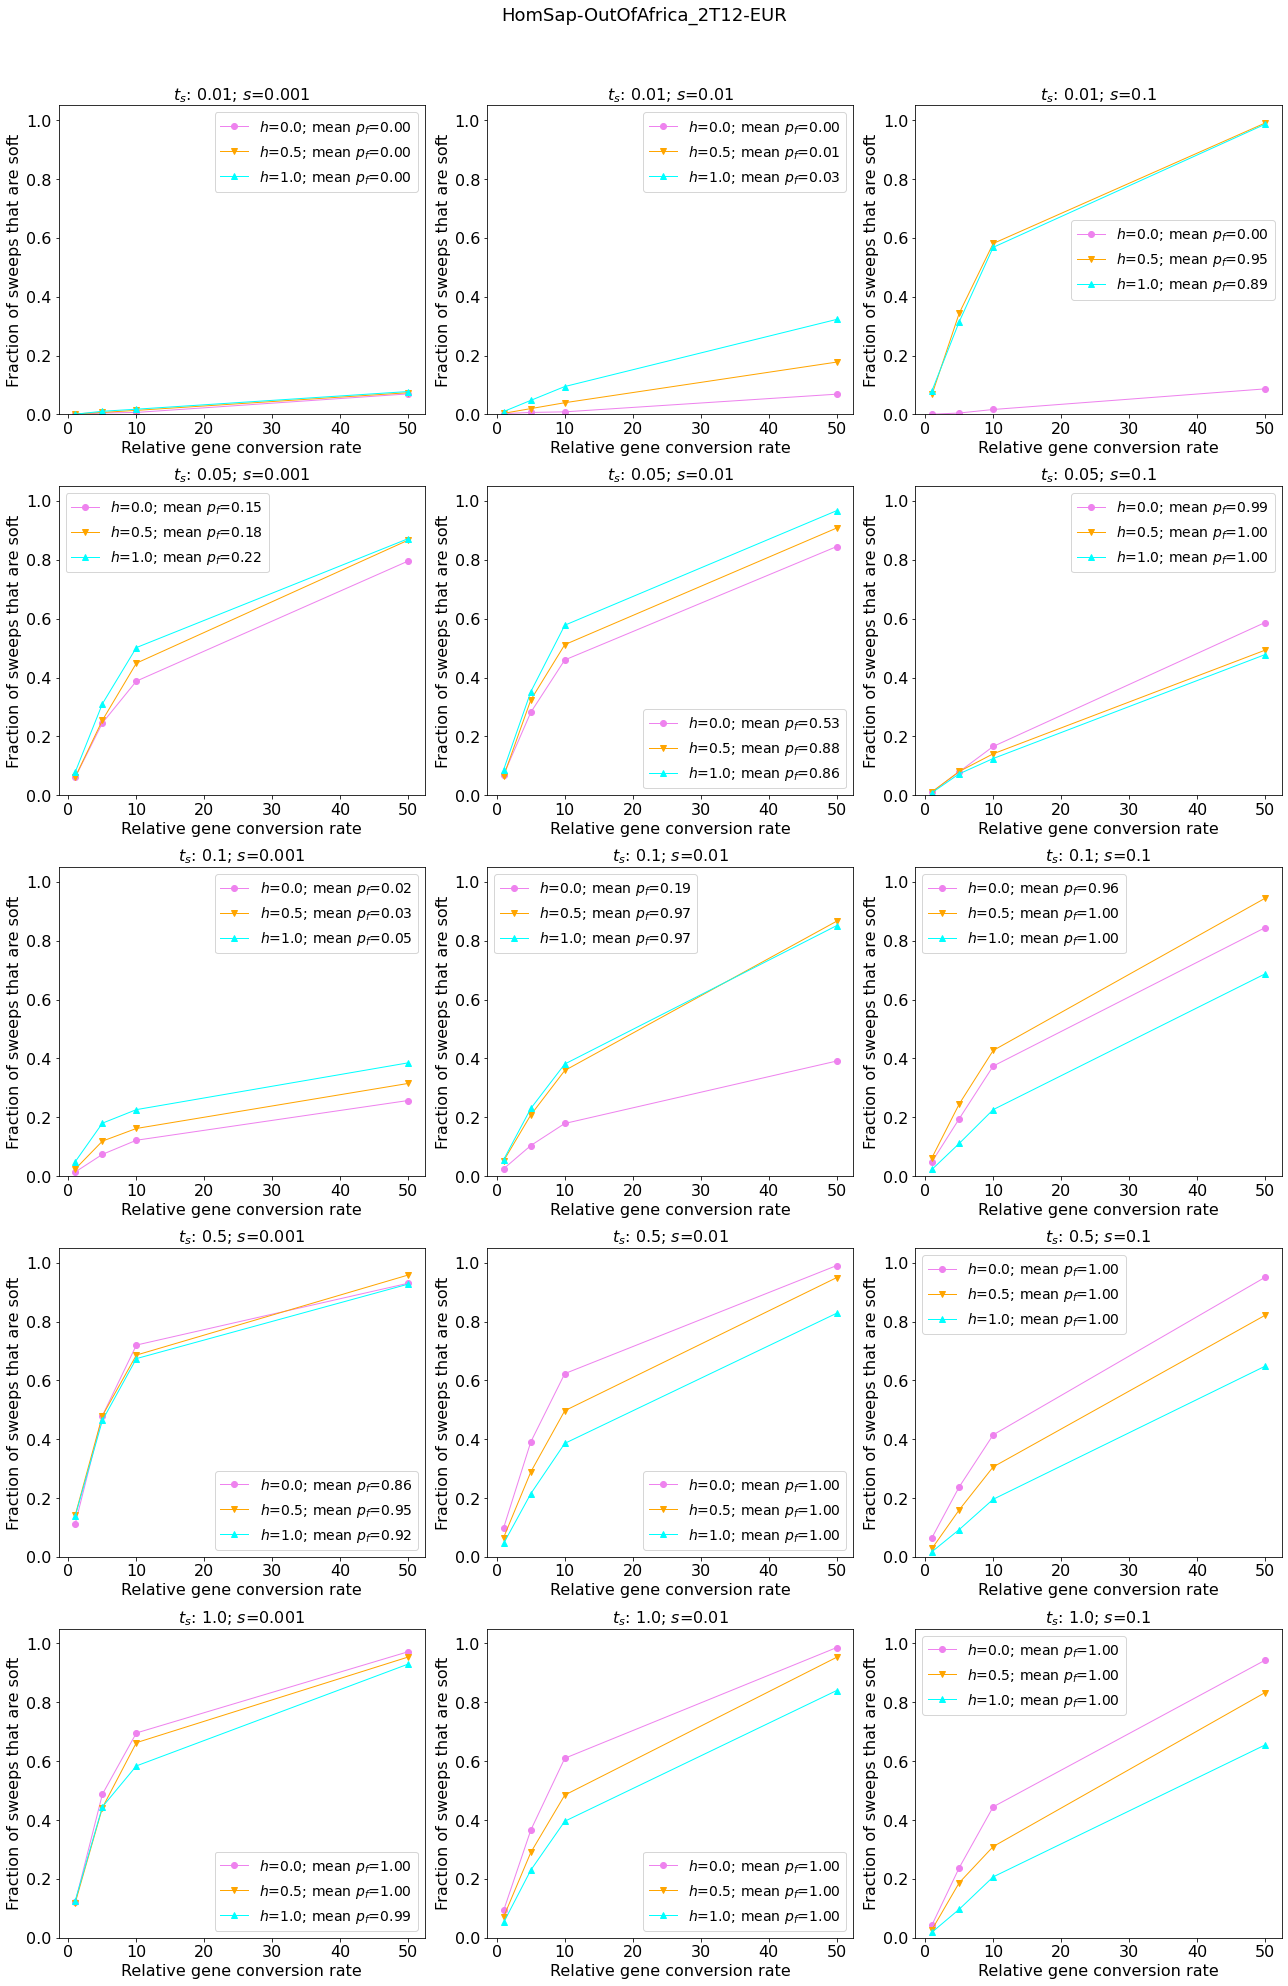

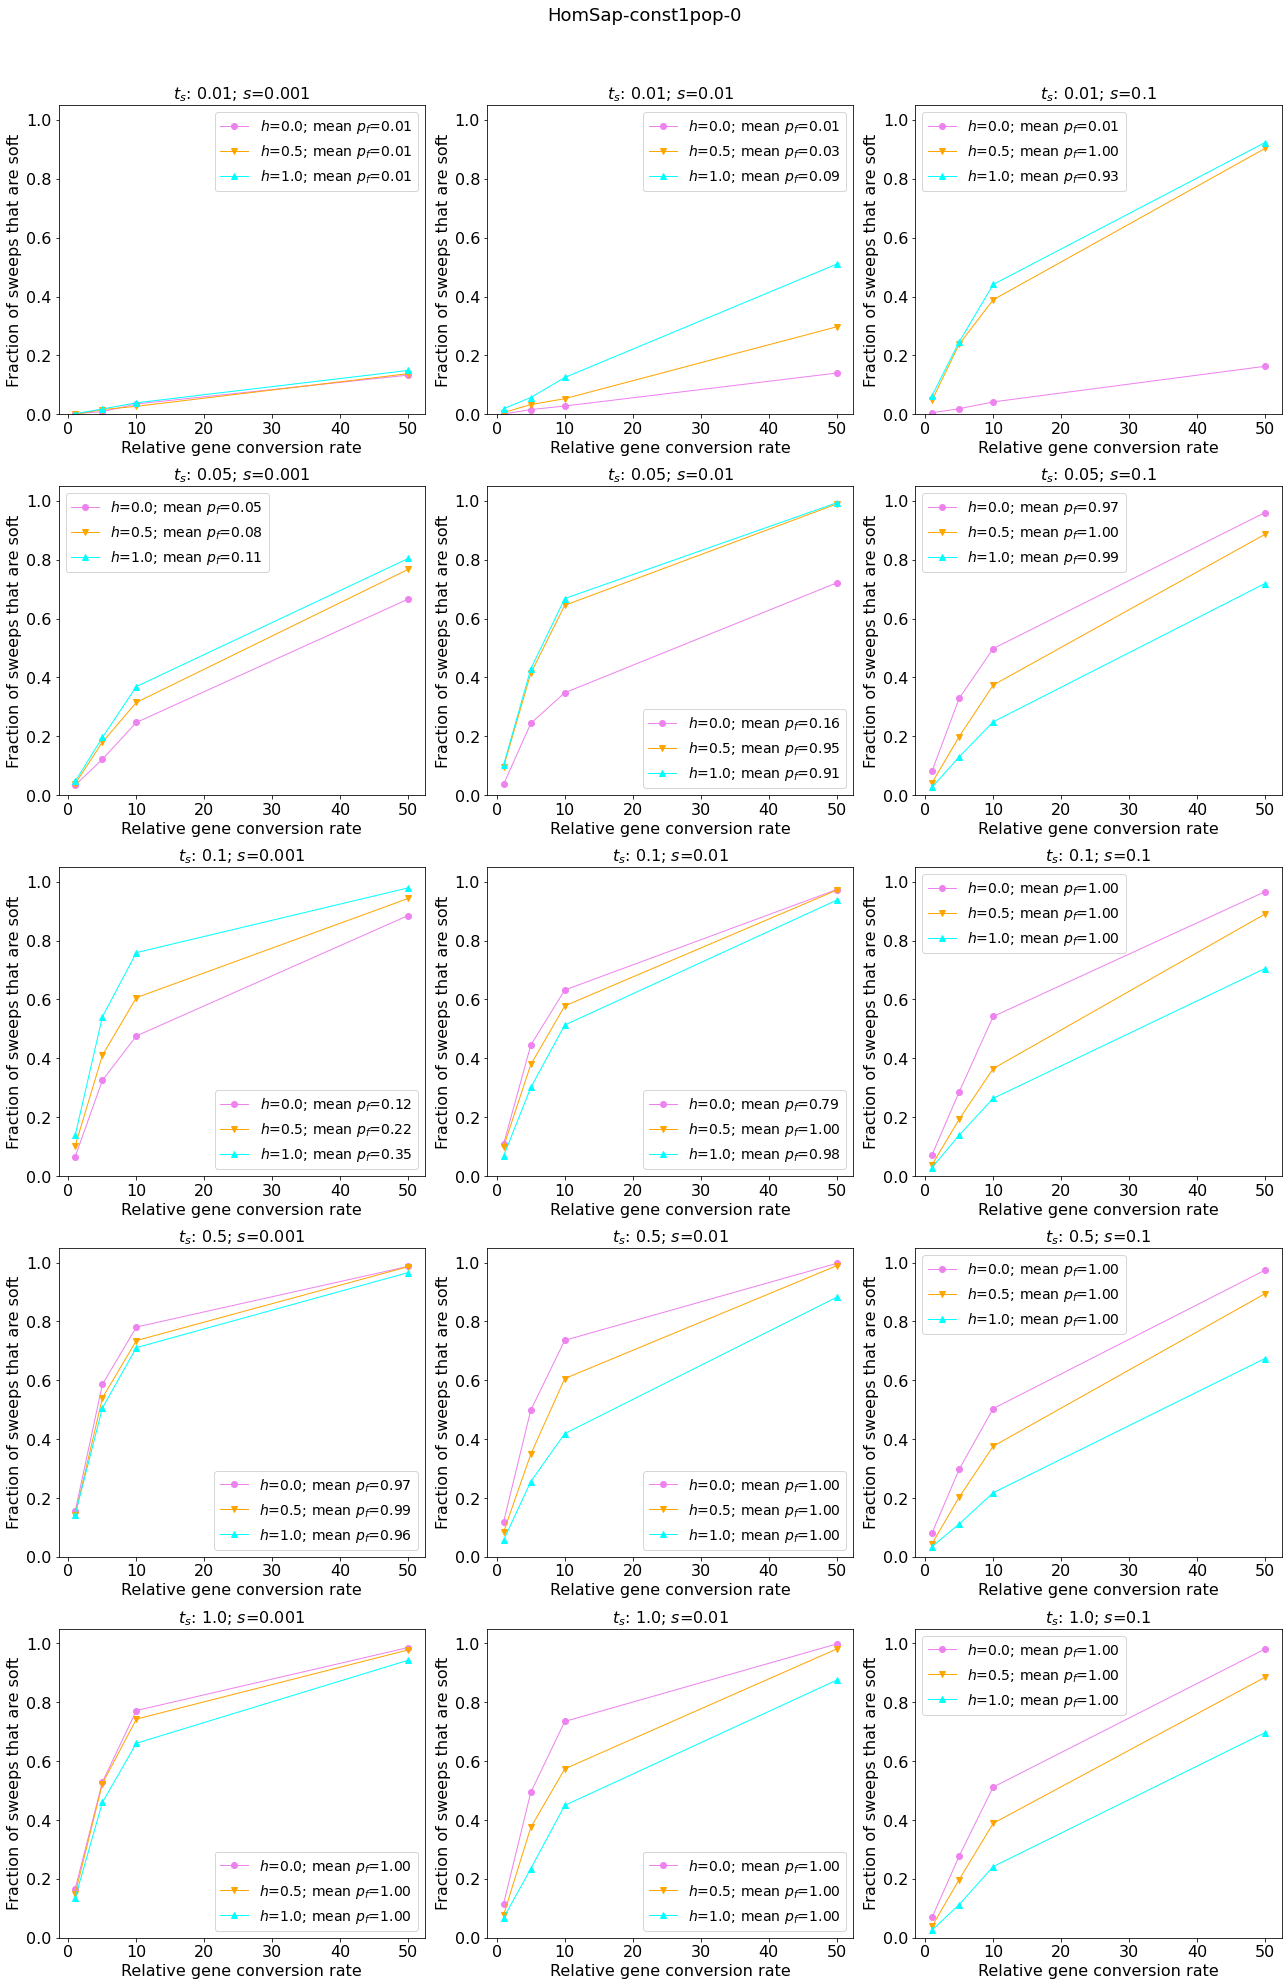

In [3]:
import matplotlib.pyplot as plt

gcRatios = sorted(table['Gene Conversion Ratio'].unique(), key=float)
selCoeffs = sorted(table['Selection Coefficient'].unique(), key=float)
sTimes = sorted(table['Sweep Start Time'].unique(), key=float)

colors = ['violet', 'orange', 'cyan', 'gray', 'brown', 'black', 'red', 'blue']
markers = ['o', 'v', '^', 'x', 's', '+', 'D', '']

for specName, demogModel, targetPop in sorted(allResults):
    table = tables[(specName, demogModel, targetPop)]
    fig, axs = plt.subplots(len(sTimes), len(selCoeffs), figsize=(18, 27))
    title = f"{specName}-{demogModel}-{targetPop}"
    fig.suptitle(title, y=1.02, fontsize=18)
    for i in range(len(sTimes)):
        for j in range(len(selCoeffs)):
            k = 0
            for dom in sorted(table['Dominance Coefficient'].unique(), key=float):
                subTable = table.loc[(table['Sweep Start Time'] == sTimes[i]) & 
                                  (table['Selection Coefficient'] == selCoeffs[j]) & 
                                  (table['Dominance Coefficient'] == dom)]
                softFracs = []
                finalFreqs = []
                for gcRatio in gcRatios:
                    currRow = subTable.loc[table['Gene Conversion Ratio'] == gcRatio]
                    fixedSoftFrac = currRow['Fraction Soft in Sample (fixed)']
                    incompleteSoftFrac = currRow['Fraction Soft in Sample (incomplete)']
                    noFix = any(currRow['Fixed %'] == "NA")
                    if noFix:
                        softFracs.append(0)
                    else:
                        fixedFrac = float(currRow['Fixed %'])
                        partialFrac = float(currRow['Partial %'])
                        softFrac = 0
                        finalFreq = 0
                        if fixedFrac > 0:
                            softFrac += float(fixedSoftFrac) * fixedFrac
                            finalFreq += 1 * fixedFrac
                        if partialFrac > 0:
                            softFrac += float(incompleteSoftFrac) * partialFrac
                            finalFreq += float(currRow['Mean Sweep Freq in Sample (incomplete)']) * partialFrac
                        softFracs.append(softFrac)
                        finalFreqs.append(finalFreq)
                domLabel = r"$h$=" + str(dom) + r"; mean $p_f$=" + f"{np.mean(finalFreqs):.2f}"
                axs[i, j].plot(gcRatios[1:], softFracs[1:], color=colors[k], marker=markers[k], lw=1, label=domLabel)
                k += 1
            axs[i, j].legend(fontsize=14)
            axs[i, j].set_title(r"$t_s$:" + f" {sTimes[i]}; " + r"$s$=" + str(selCoeffs[j]), fontsize=16)
            axs[i, j].set_ylim(0, 1.05)
            axs[i, j].set_xlabel('Relative gene conversion rate', fontsize=16)
            axs[i, j].set_ylabel('Fraction of sweeps that are soft', fontsize=16)
            axs[i, j].tick_params(axis='both', labelsize=16)
    fig.tight_layout()
    plt.savefig(f"figs/{title}.pdf")



## How soft are pseudo-soft sweeps produced by gene conversion?
Now we are going to ask what the final sample frequency of the recombinant haplotype is at the time of sampling, on average, for each parameter combination. We are going to read in our summary files again, but take less information from them this time (just the final frequency of the recombinant haplotype). Let's define a function to do this for us:

In [4]:
def parseRecombFreqsFromSummaryFile(summaryFileName):
    with open(summaryFileName, 'rt') as sf:
        m3FreqsSamp = []
        for line in sf:
            repNum, isGoodRep, isFixed, isFixedSoftPop, m3freqPop, isFixedSoftSamp, m3CountSamp, n, isPartialSoftSamp, \
            m3PartialCountSamp, m3PartialDenomSamp, sojournTime, restartCount = line.strip().split()
            if isGoodRep == "1":
                if isFixed == "1":
                    if int(isFixedSoftSamp):
                        m3Freq = int(m3CountSamp)/int(n)
                        m3FreqsSamp.append(m3Freq)
    return m3FreqsSamp

Now we can read in each summary file, grab the information we need, and make our violin plots showing the distribution of recombinant haplotype frequencies. We start with just the constant-size demographic models for each species, and limit ourselves to the oldest sweeps (which we know reached fixation in each case).

Yes, there are cleaner ways to do this, but I like to roll my own with dictionaries of dictionaries. Deal with it!

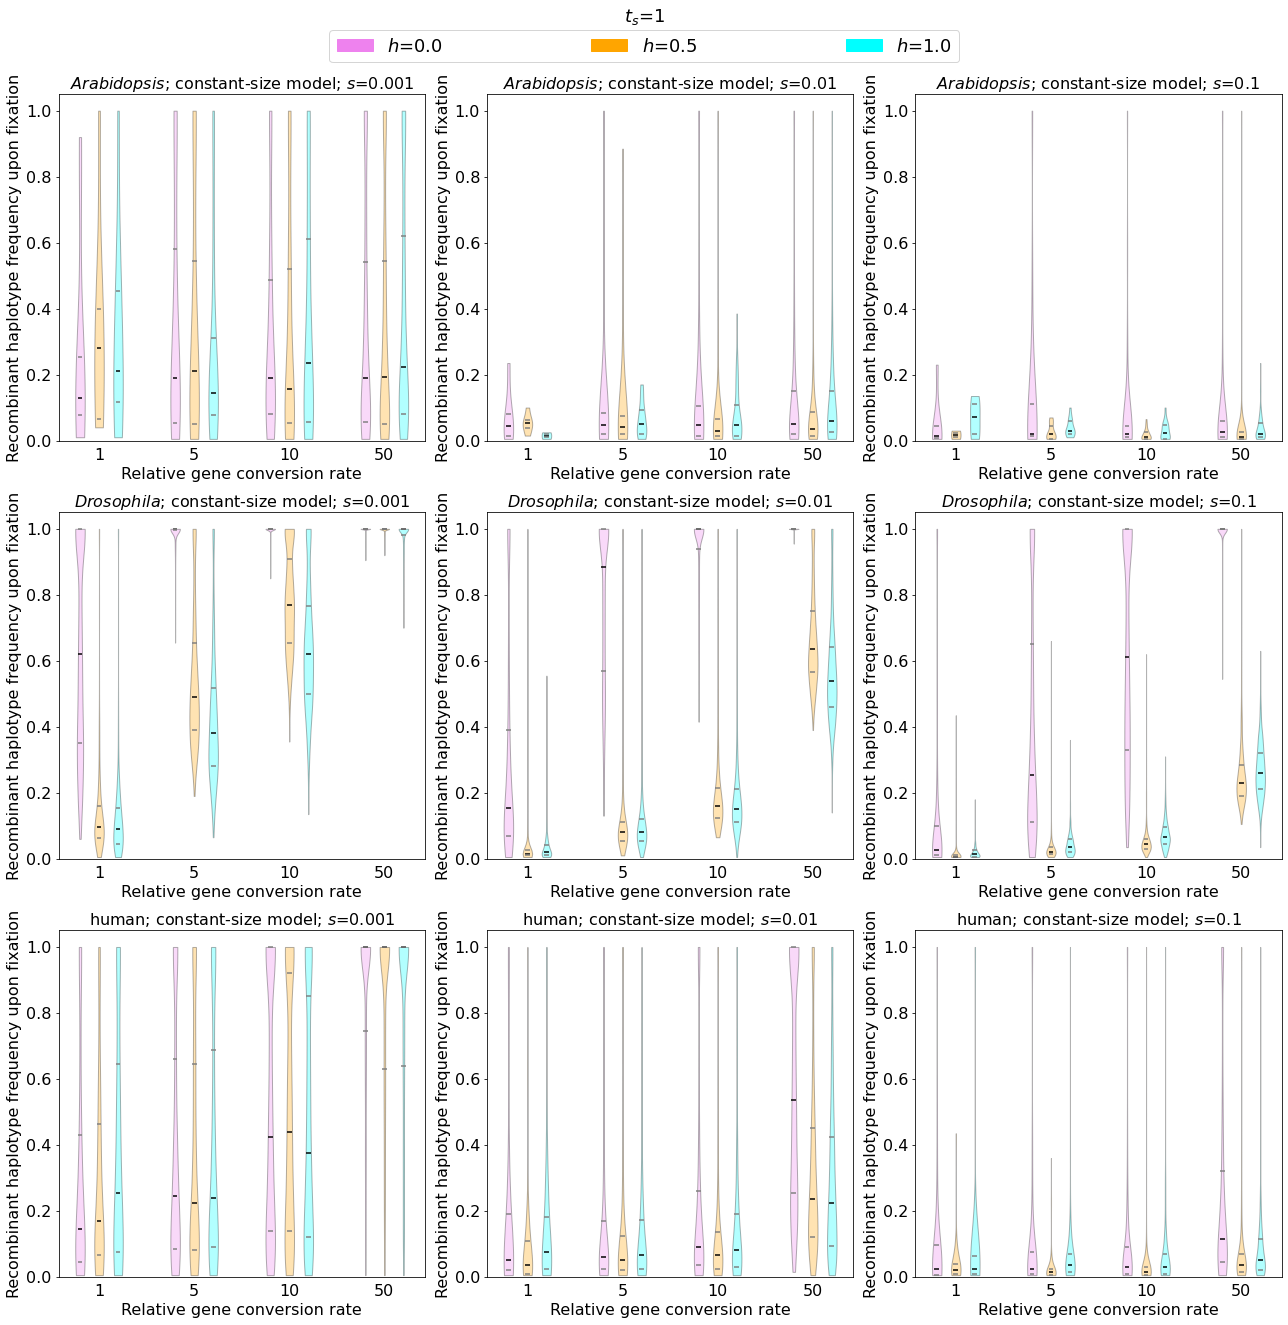

In [7]:
import matplotlib.patches as mpatches

allResults = {}
sTimes, selCoeffs, gcRatios, specNames = {}, {}, {}, {}
for fName in os.listdir(summaryOutDir):
    specName, demogModel, mapName, contigName, targetPop, popNumber, sampleSize, Q, selCoeff, domCoeff, selTime, \
    geneConvRatio = fName.rstrip(".txt").split("-")
    geneConvRatio = int(geneConvRatio)
    
    if geneConvRatio > 0:
        m3FreqsSamp = parseRecombFreqsFromSummaryFile(summaryOutDir + "/" + fName)
        mainKey = (specName, demogModel, targetPop)
        subKey = (selCoeff, selTime)

        
        sTimes[selTime] = 1
        selCoeffs[selCoeff] = 1
        gcRatios[geneConvRatio] = 1
        specNames[specName] = 1
    
        if not mainKey in allResults:
            allResults[mainKey] = {}
        if not subKey in allResults[mainKey]:
            allResults[mainKey][subKey] = {}
        if not domCoeff in allResults[mainKey][subKey]:
            allResults[mainKey][subKey][domCoeff] = {}
        if not geneConvRatio in allResults[mainKey][subKey][domCoeff]:
            allResults[mainKey][subKey][domCoeff][geneConvRatio] = m3FreqsSamp

sTimes = list(sorted(sTimes))
selTime = sTimes[-1]

selCoeffs = list(sorted(selCoeffs, key=float))
gcRatios = list(sorted(gcRatios, key=float))
colors = ['violet', 'orange', 'cyan', 'gray', 'brown', 'black', 'red', 'blue']

positions, pltColors, labelPos = [], [], []
pos = 0
xticklabels = []
for gcRatio in gcRatios:
    for i in range(3):
        positions.append(pos+i+1)
        pltColors.append(colors[i])
    labelPos.append(positions[-2])
    xticklabels += ["",gcRatio,""]
    pos += 5

fig, axs = plt.subplots(len(specNames), len(selCoeffs), figsize=(18, 18))
title = r"$t_s$=" + selTime
fig.suptitle(title, y=1.02, fontsize=18)

def printSpeciesName(specName):
    if specName == "HomSap":
        return "human"
    elif specName == "DroMel":
        return r"$Drosophila$"
    elif specName == "AraTha":
        return r"$Arabidopsis$"

i = 0
for mainKey in sorted(allResults):
    specName, demogModel, targetPop = mainKey
    if demogModel == "const1pop":
        for j in range(len(selCoeffs)):
            subKey = (selCoeffs[j], selTime)
            pltData = []
            for gcRatio in gcRatios:
                recessiveM3Freqs = allResults[mainKey][subKey]['0.0'][gcRatio]
                additiveM3Freqs = allResults[mainKey][subKey]['0.5'][gcRatio]
                dominantM3Freqs = allResults[mainKey][subKey]['1.0'][gcRatio]

                currData = [recessiveM3Freqs, additiveM3Freqs, dominantM3Freqs]
                currData = [x if x else [0] for x in currData]
                pltData += currData
        
            vplot = axs[i, j].violinplot(pltData, positions=positions, showmedians=True, showextrema=False, quantiles=[[0.25, 0.75]]*len(pltData))
            
            k = 0
            for violin in vplot['bodies']:
                violin.set_facecolor(pltColors[k])
                violin.set_edgecolor('black')
                k += 1
            vplot['cmedians'].set_colors('black')
            vplot['cquantiles'].set_colors('gray')

            axs[i, j].set_title(f"{printSpeciesName(specName)}; constant-size model; " + r"$s$=" + str(selCoeffs[j]), fontsize=16)
            axs[i, j].set_xlabel('Relative gene conversion rate', fontsize=16)
            axs[i, j].set_ylabel('Recombinant haplotype frequency upon fixation', fontsize=16)
            axs[i, j].tick_params(axis='both', labelsize=16)
            axs[i, j].set_ylim(0, 1.05)
            axs[i, j].set_xticks(labelPos)
            axs[i, j].xaxis.set_ticks_position('none')
            axs[i, j].set_xticklabels(gcRatios)        
        i += 1

handles = [mpatches.Patch(color=pltColors[0], label=r"$h$=0.0"),
           mpatches.Patch(color=pltColors[1], label=r"$h$=0.5"),
           mpatches.Patch(color=pltColors[2], label=r"$h$=1.0")]

fig.legend(handles=handles, loc='lower left', bbox_to_anchor=(0.25, 0.97, 0.5, .101), mode = "expand", ncol = len(handles), fontsize=18)
fig.tight_layout()
plt.savefig(f"figs/softness_allConst_ts1.pdf")

Finally, we finish by generating these violin plots for each sweep timing for each demographic model for each species:

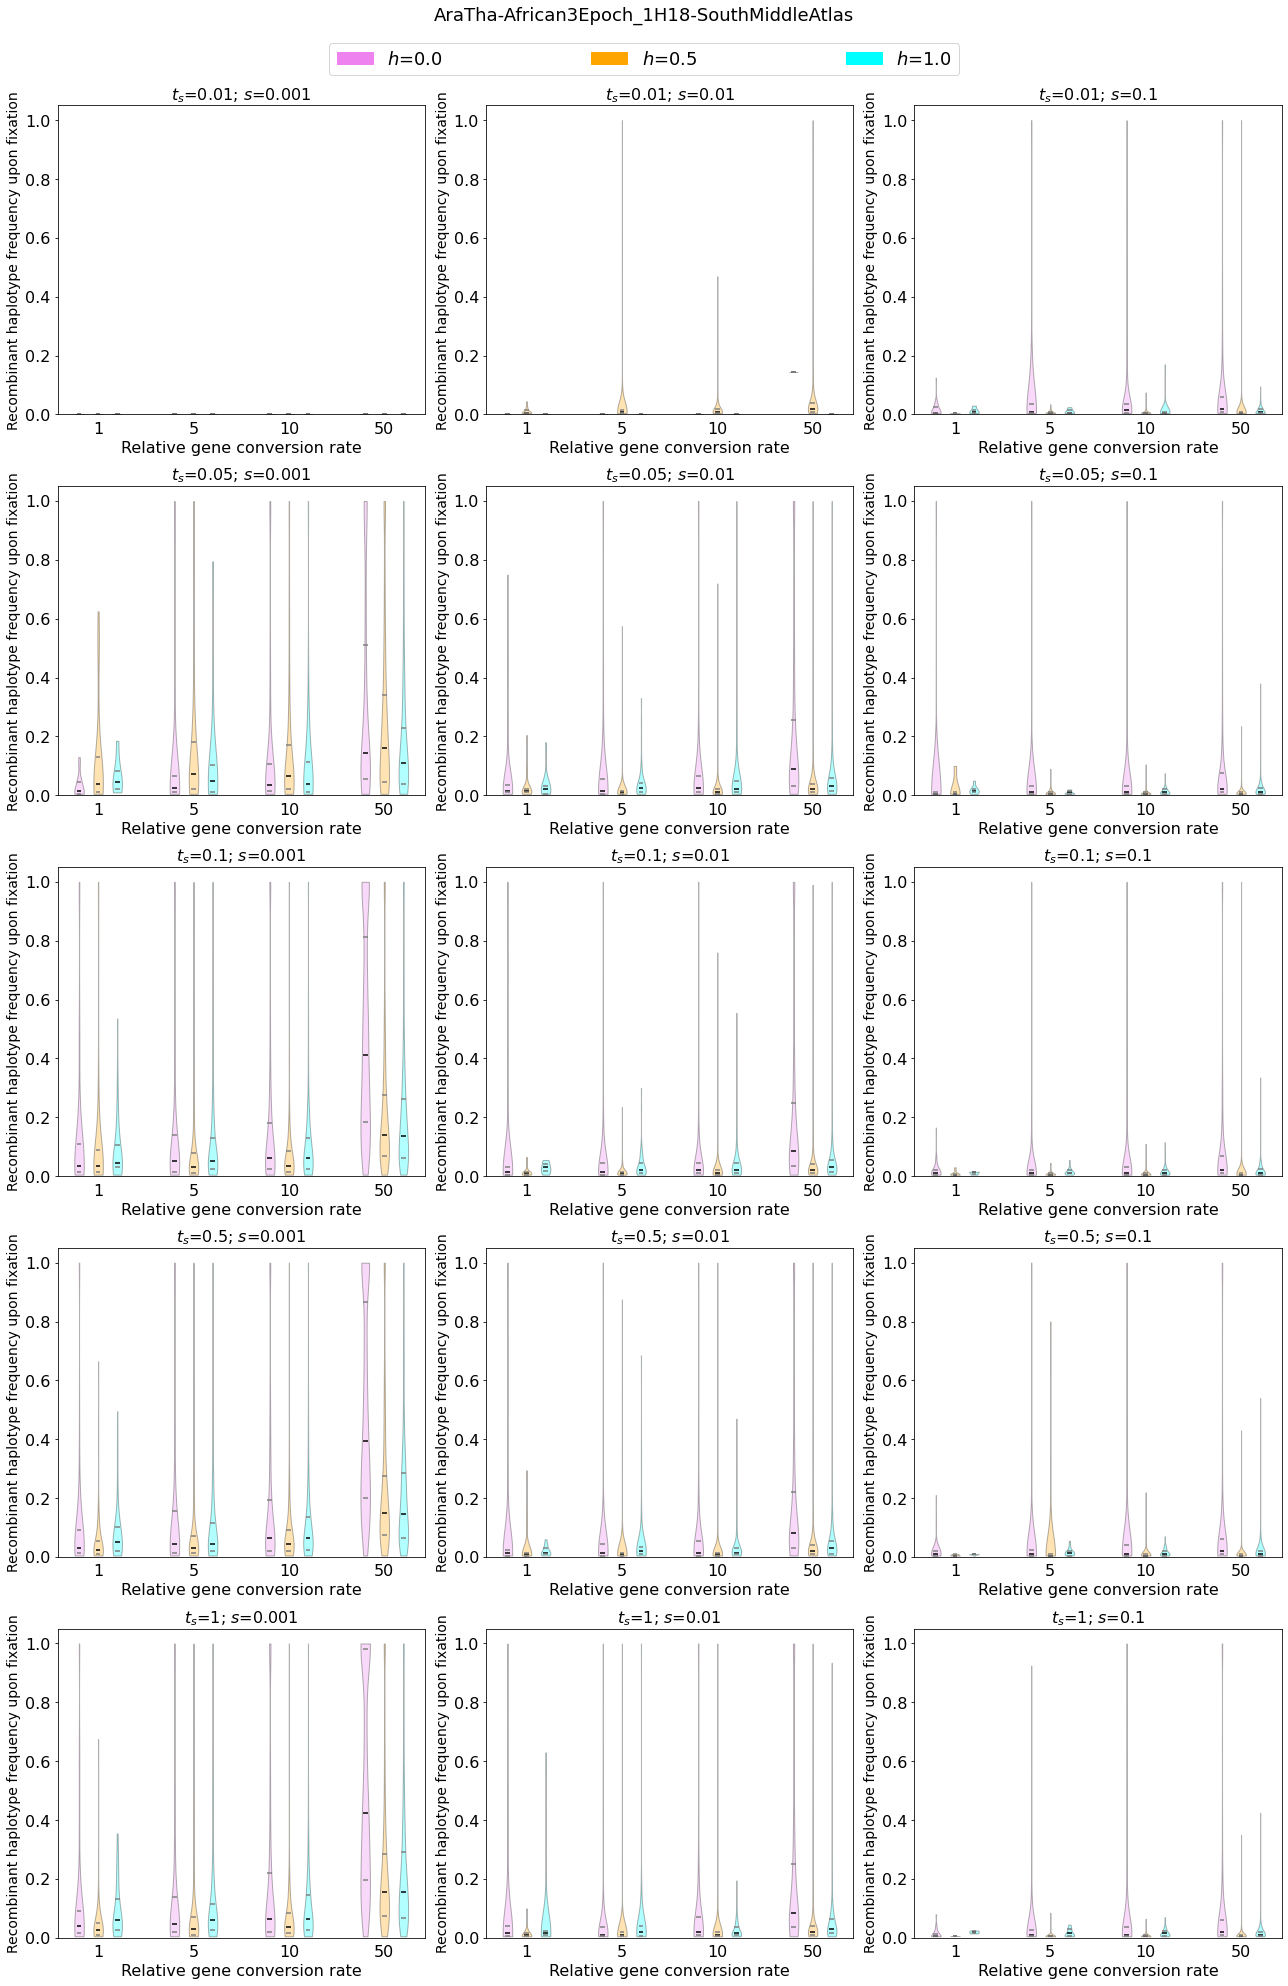

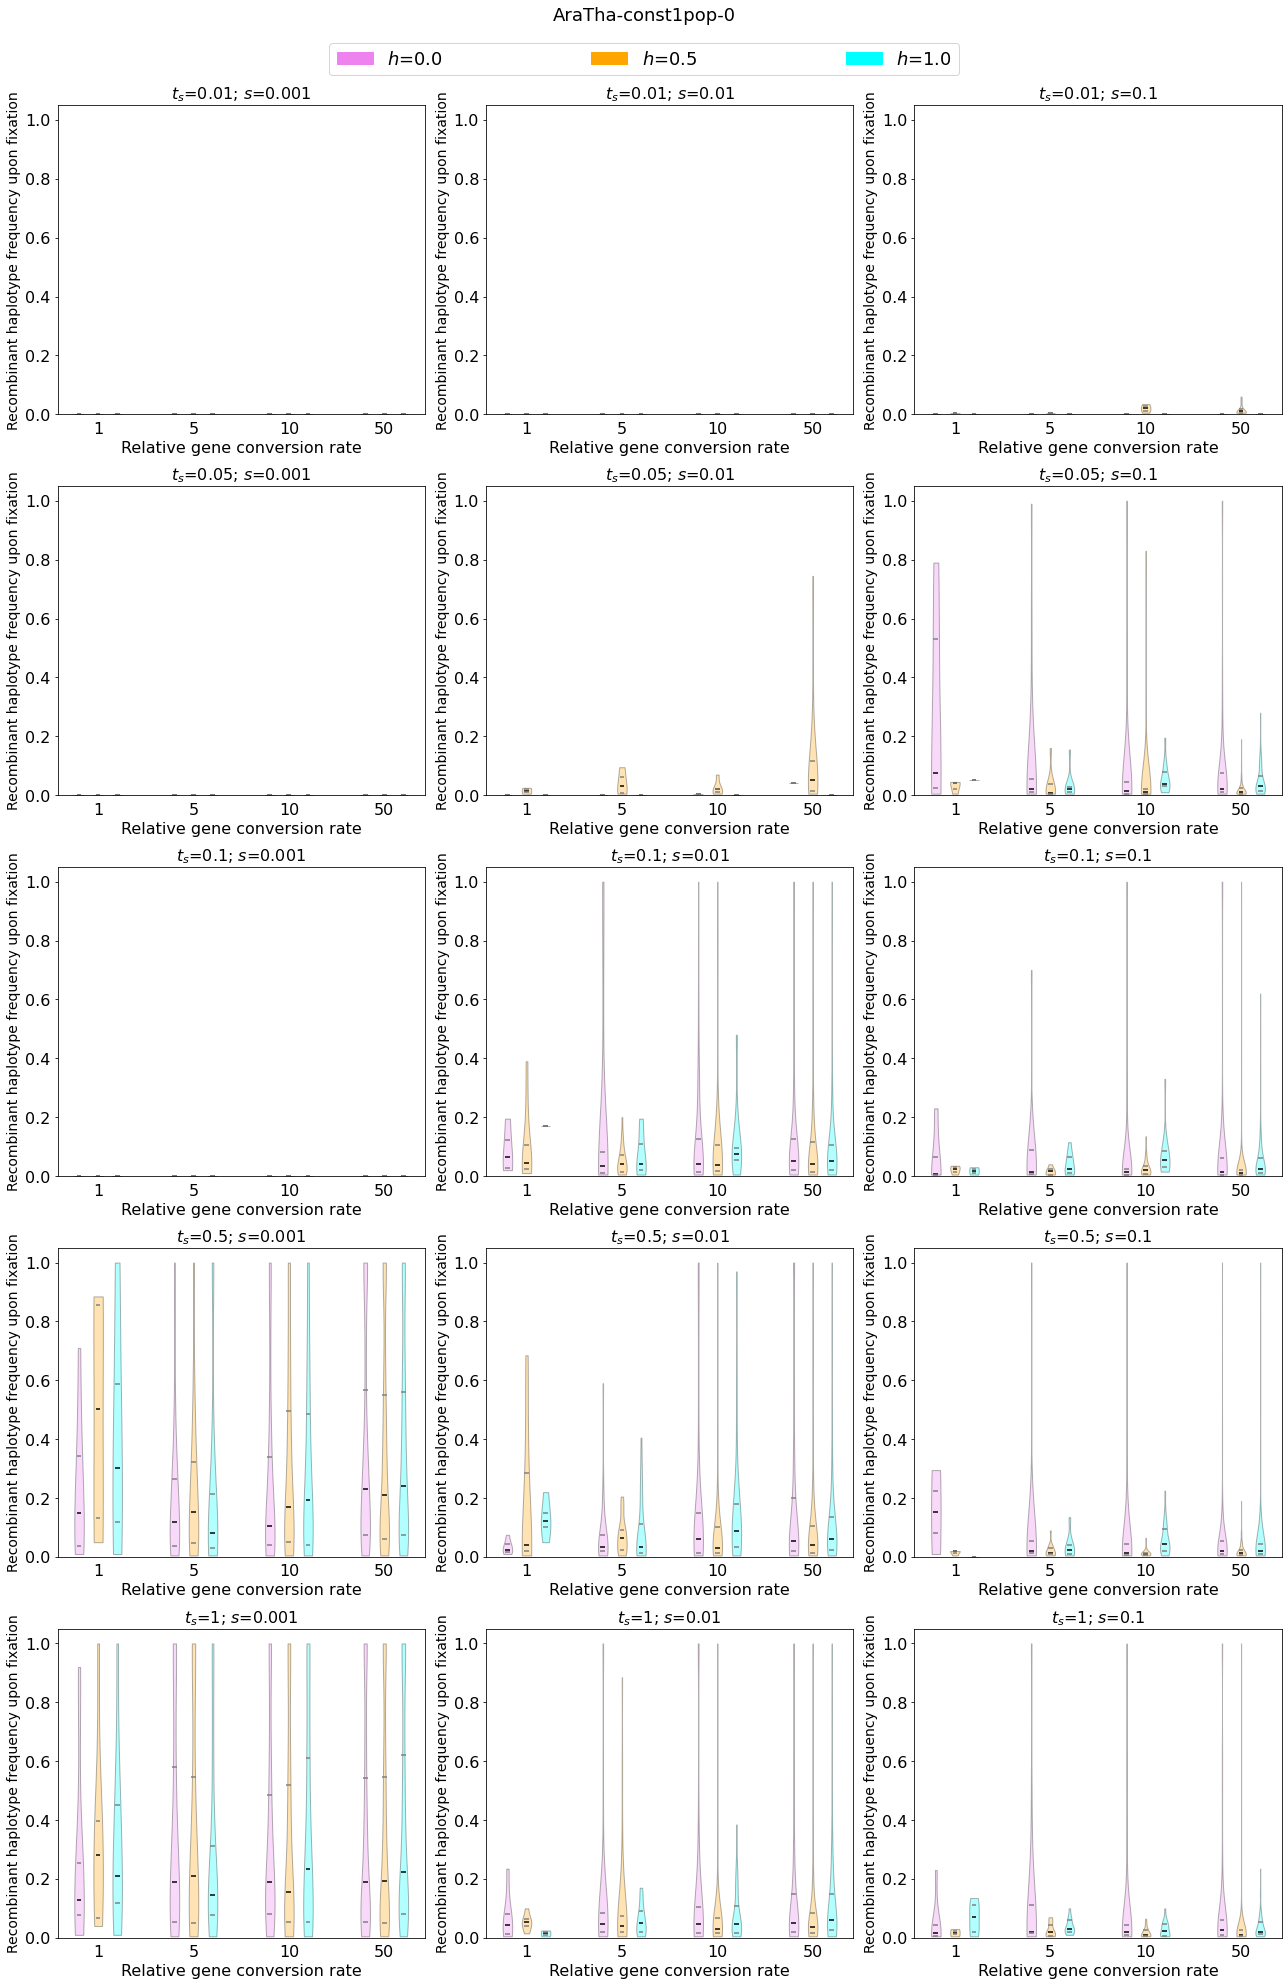

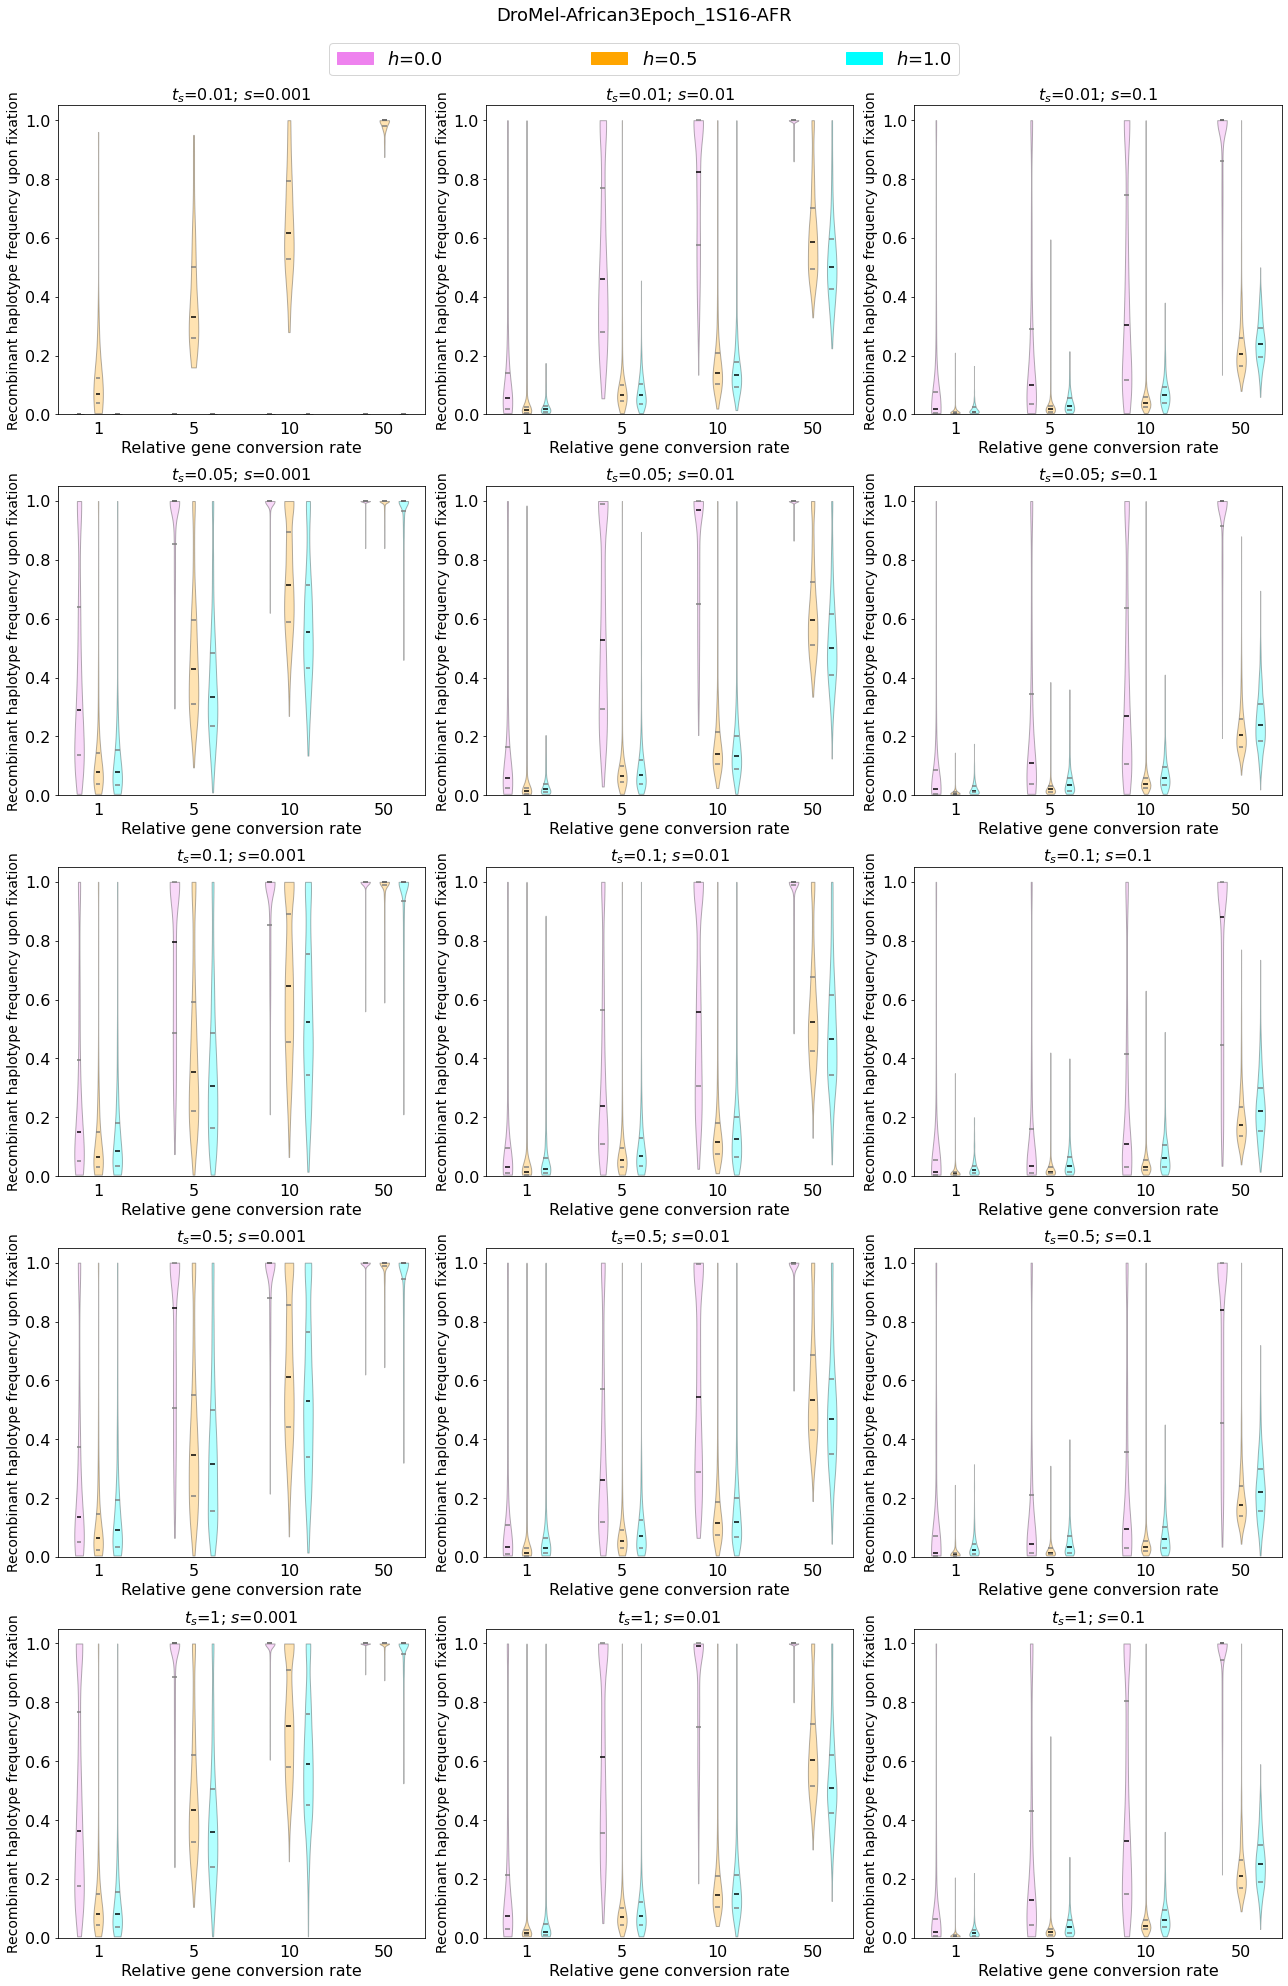

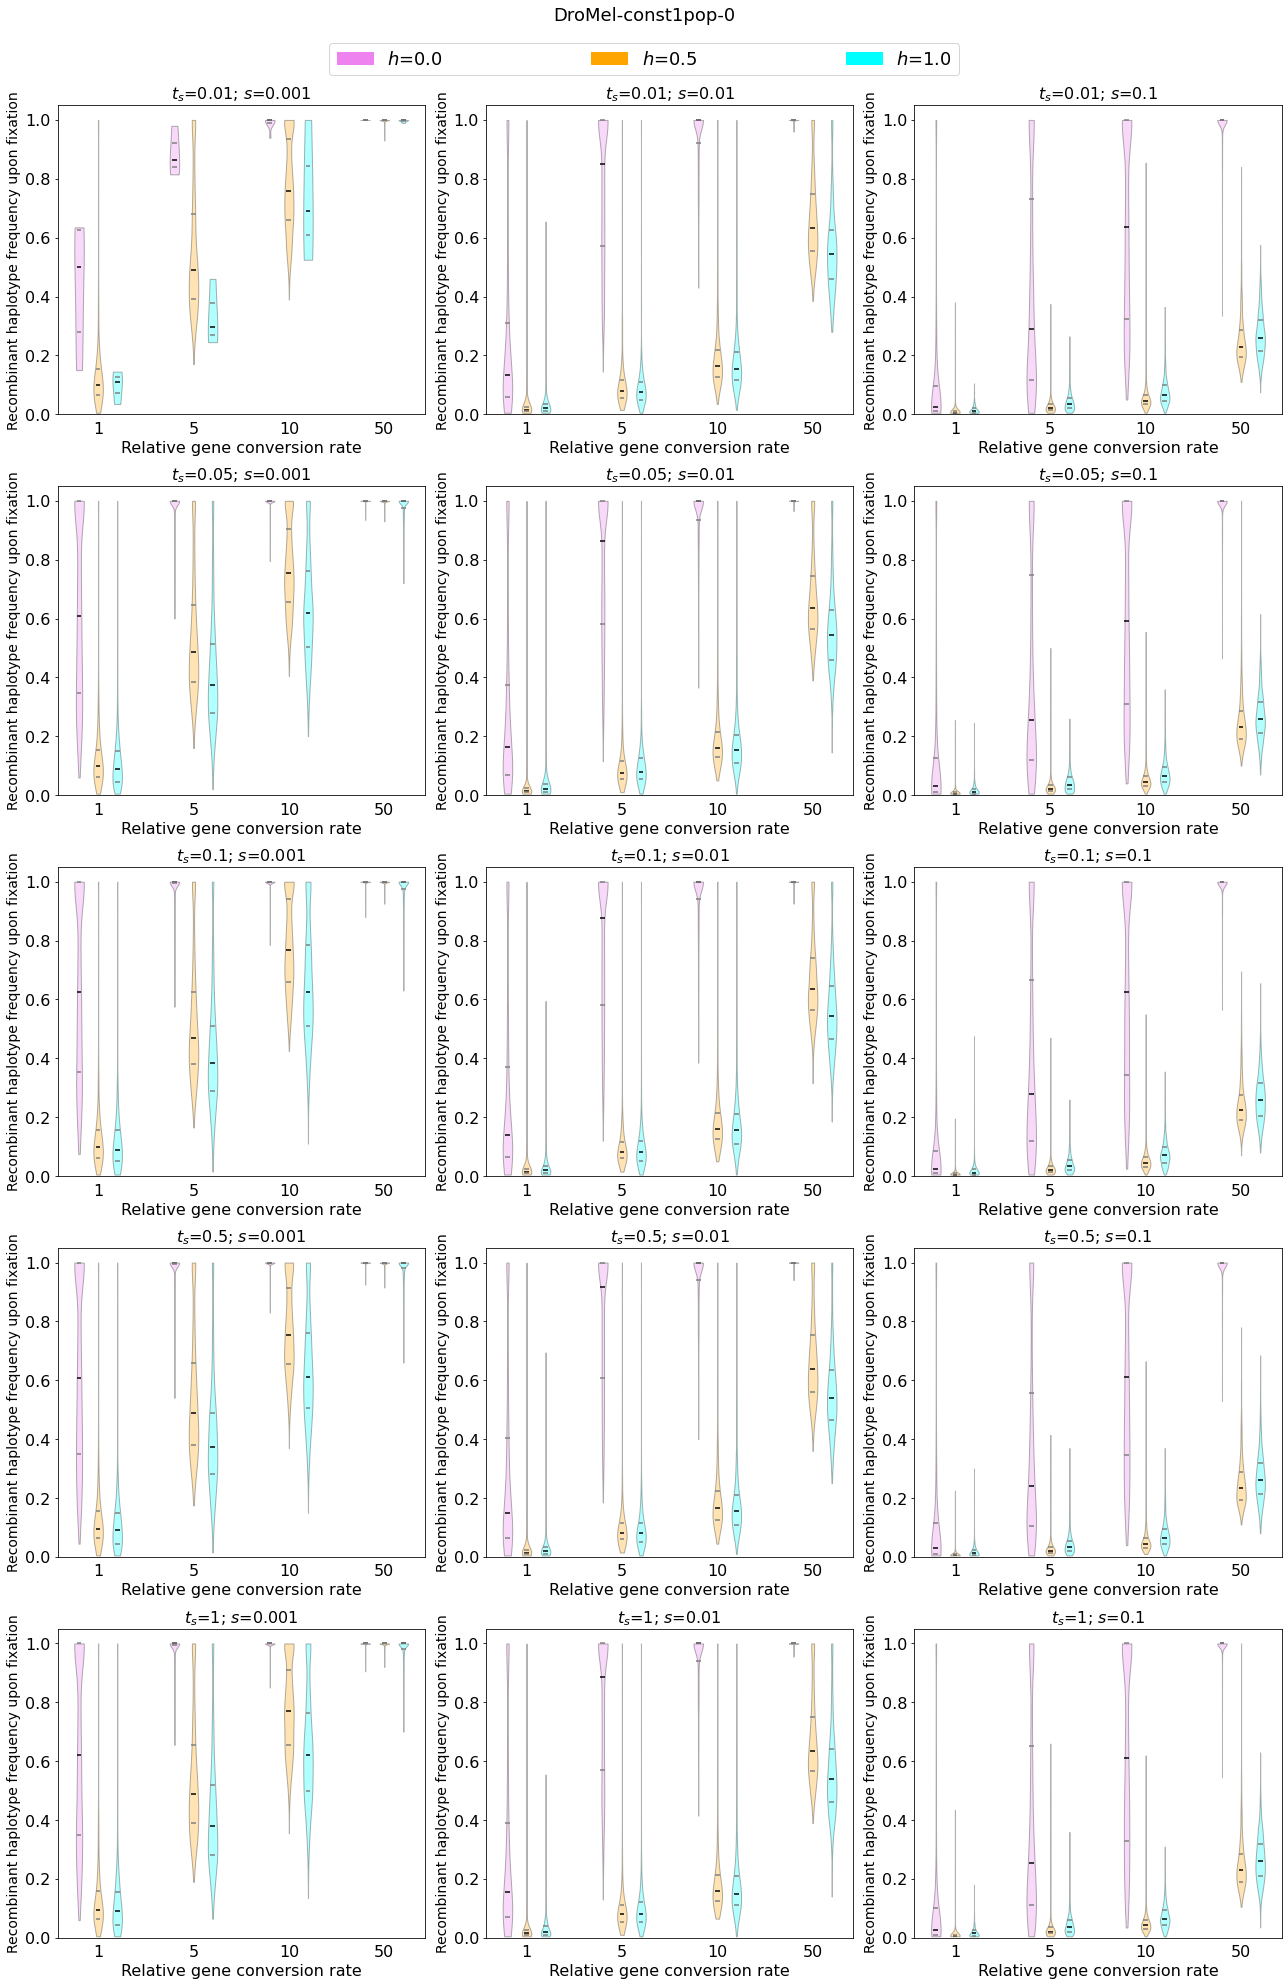

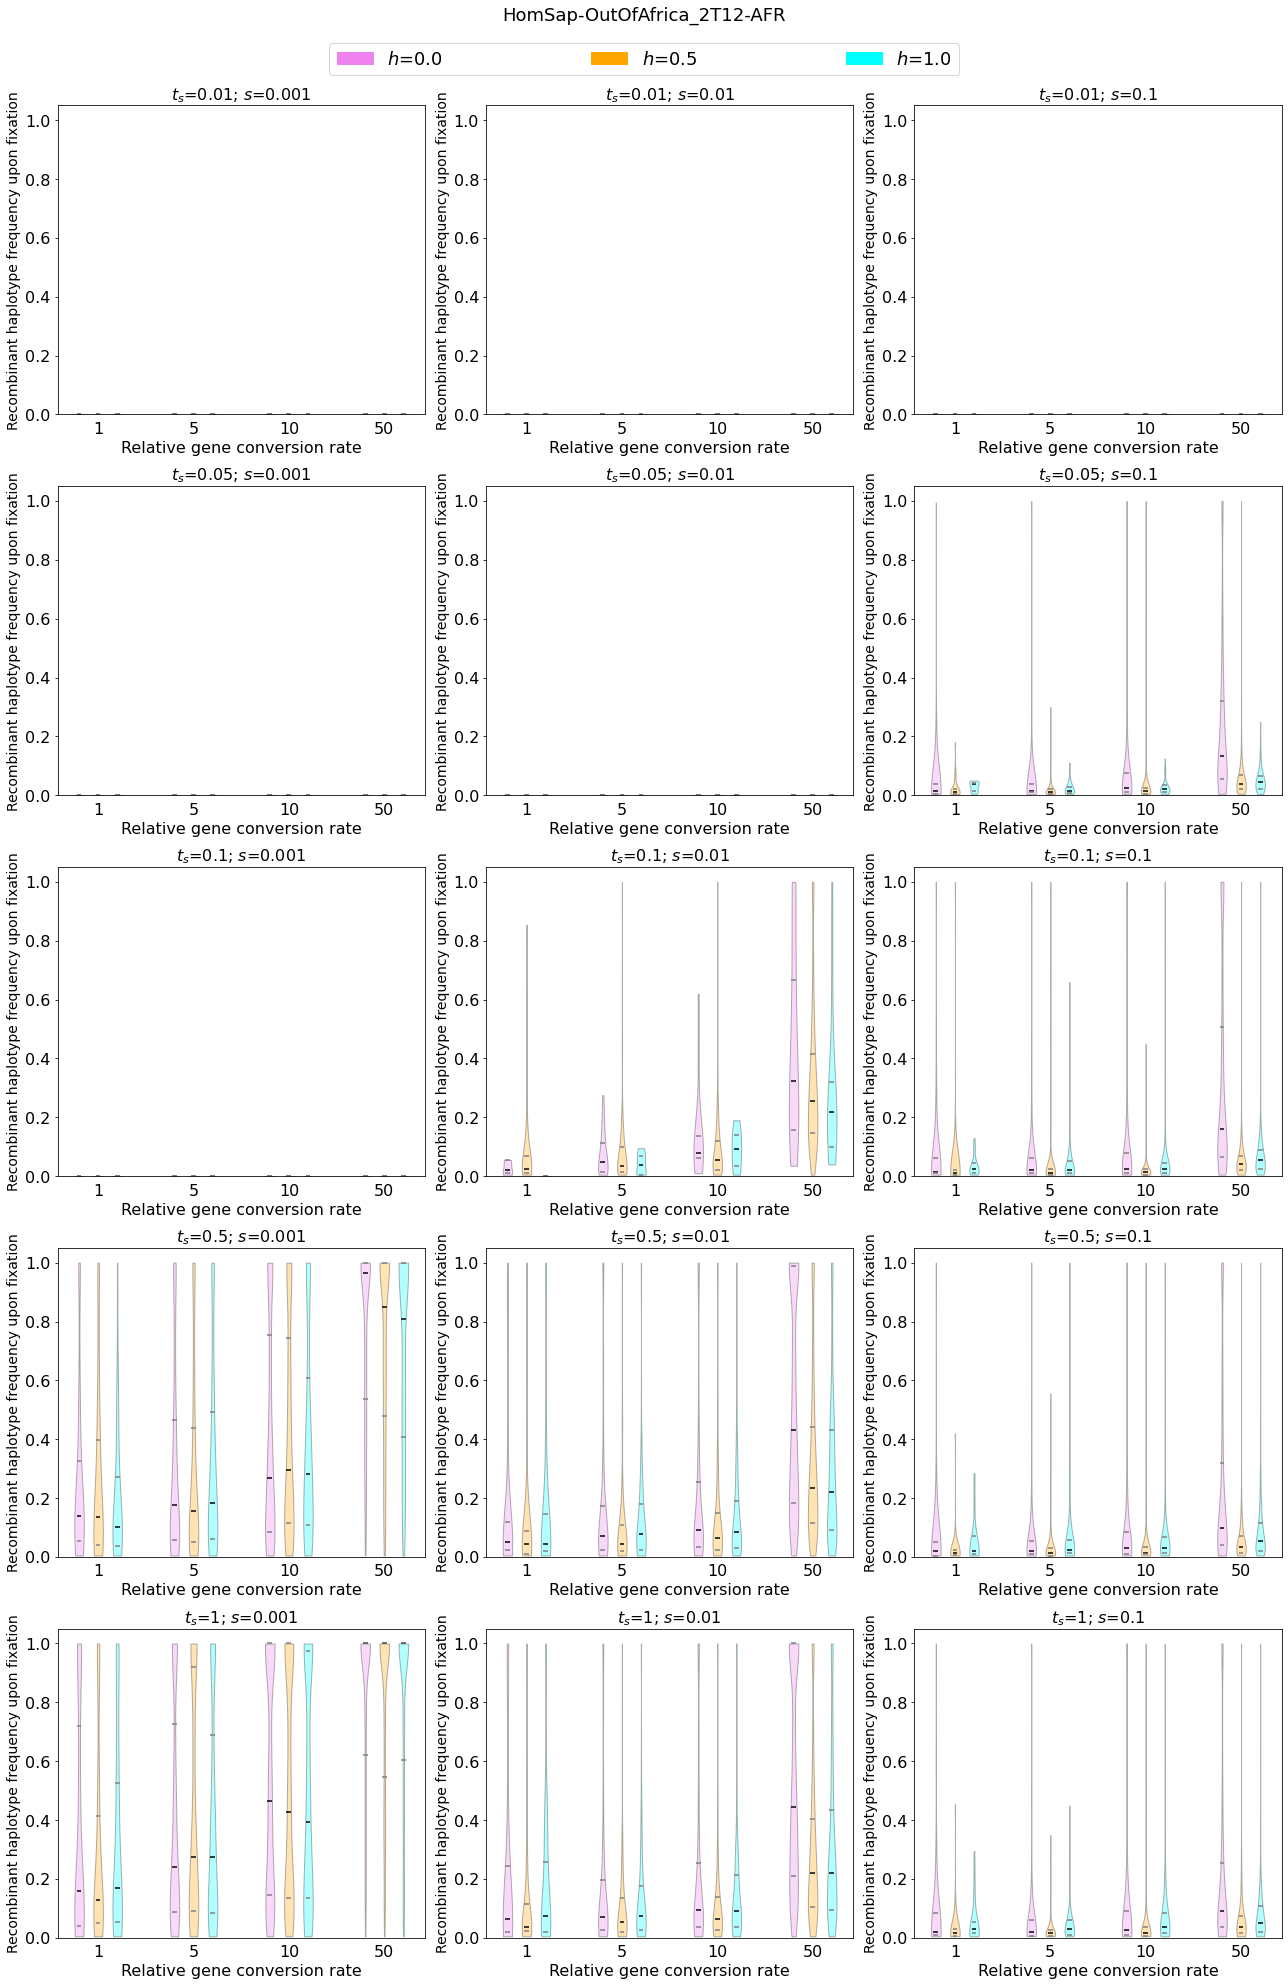

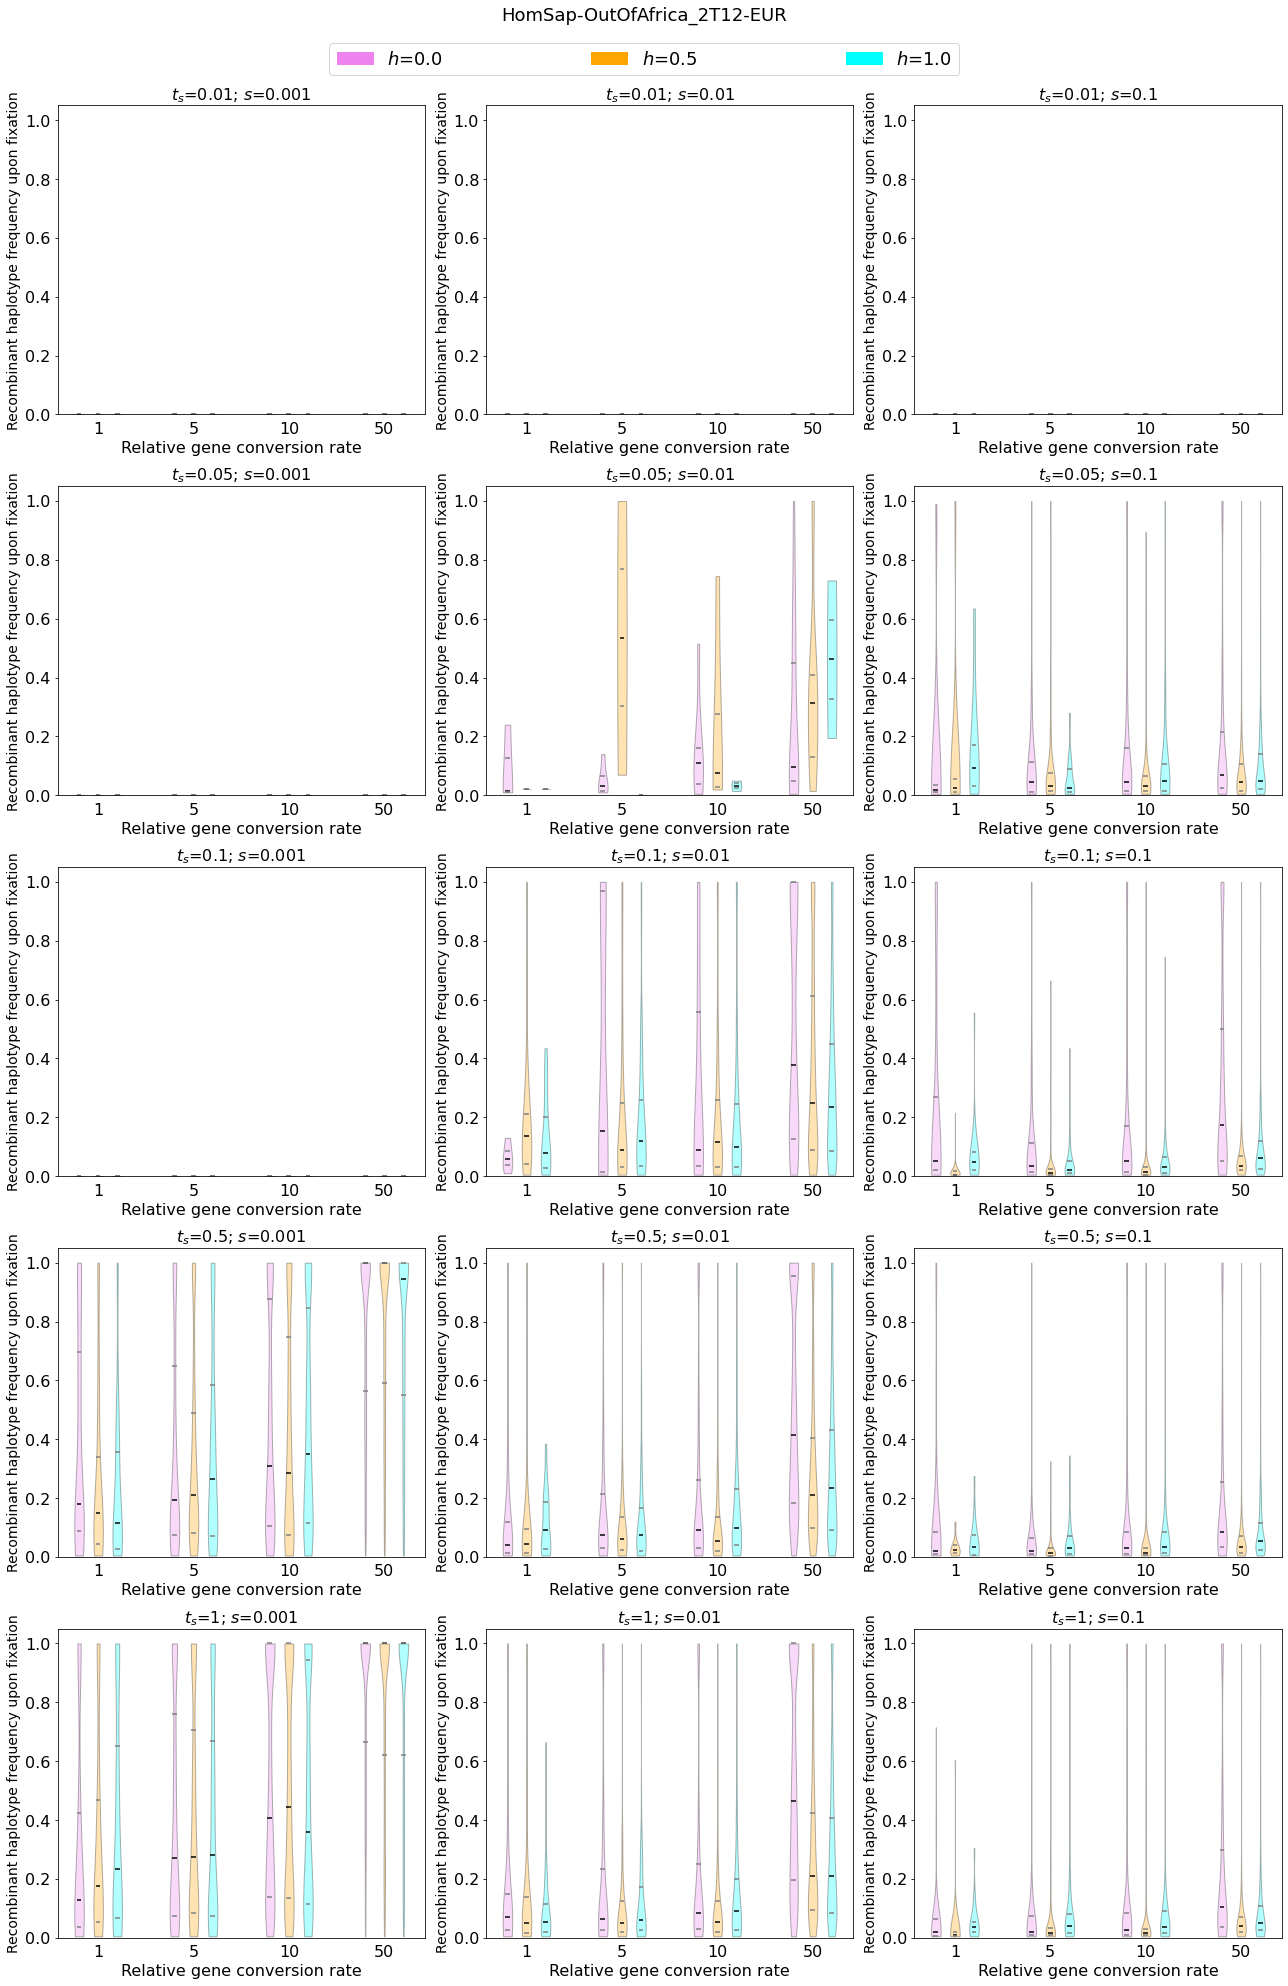

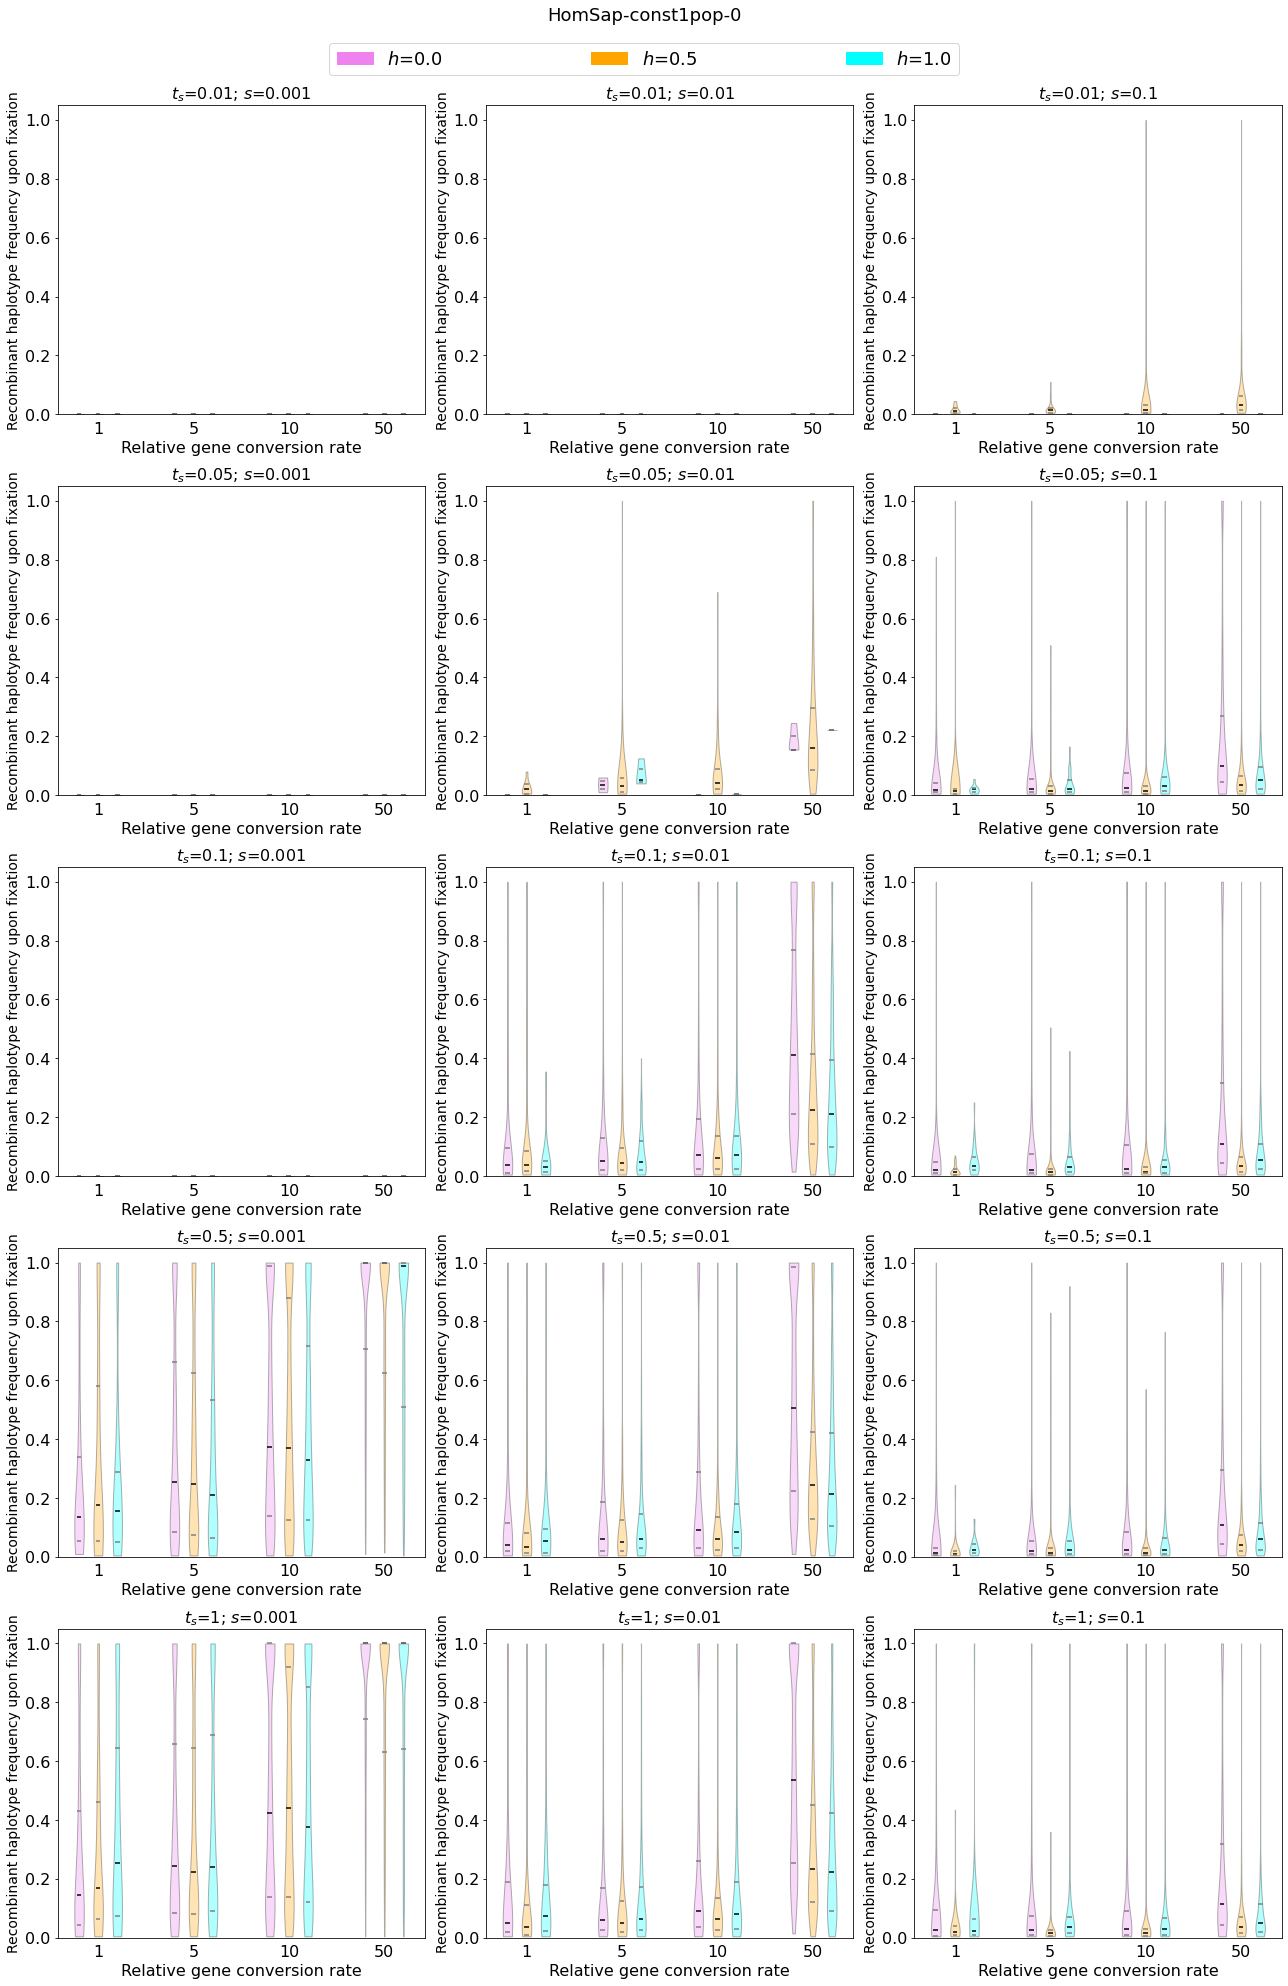

In [9]:
positions, pltColors, labelPos = [], [], []
pos = 0
xticklabels = []
for gcRatio in gcRatios:
    for i in range(3):
        positions.append(pos+i+1)
        pltColors.append(colors[i])
    xticklabels += ["",gcRatio,""]
    labelPos.append(positions[-2])
    pos += 5

for mainKey in sorted(allResults):
    specName, demogModel, targetPop = mainKey
    fig, axs = plt.subplots(len(sTimes), len(selCoeffs), figsize=(18, 27))
    title = f"{specName}-{demogModel}-{targetPop}"
    fig.suptitle(title, y=1.02, fontsize=18)

    for i in range(len(sTimes)):
        for j in range(len(selCoeffs)):
            subKey = (selCoeffs[j], sTimes[i])
            pltData = []
            for gcRatio in gcRatios:
                recessiveM3Freqs = allResults[mainKey][subKey]['0.0'][gcRatio]
                additiveM3Freqs = allResults[mainKey][subKey]['0.5'][gcRatio]
                dominantM3Freqs = allResults[mainKey][subKey]['1.0'][gcRatio]
                currData = [recessiveM3Freqs, additiveM3Freqs, dominantM3Freqs]
                currData = [x if x else [0] for x in currData]
                pltData += currData
            
            vplot = axs[i, j].violinplot(pltData, positions=positions, showmedians=True, showextrema=False, quantiles=[[0.25, 0.75]]*len(pltData))
            
            k = 0
            for violin in vplot['bodies']:
                violin.set_facecolor(pltColors[k])
                violin.set_edgecolor('black')
                k += 1
            vplot['cmedians'].set_colors('black')
            vplot['cquantiles'].set_colors('gray')

            
            axs[i, j].set_title(r"$t_s$=" + f"{sTimes[i]}; " + r"$s$=" + str(selCoeffs[j]), fontsize=16)
            axs[i, j].set_xlabel('Relative gene conversion rate', fontsize=16)
            axs[i, j].set_ylabel('Recombinant haplotype frequency upon fixation', fontsize=14)
            axs[i, j].tick_params(axis='both', labelsize=16)
            axs[i, j].set_ylim(0, 1.05)
            axs[i, j].set_xticks(labelPos)
            axs[i, j].xaxis.set_ticks_position('none')
            axs[i, j].set_xticklabels(gcRatios)

    handles = [mpatches.Patch(color=pltColors[0], label=r"$h$=0.0"),
               mpatches.Patch(color=pltColors[1], label=r"$h$=0.5"),
               mpatches.Patch(color=pltColors[2], label=r"$h$=1.0")]

    fig.legend(handles=handles, loc='lower left', bbox_to_anchor=(0.25, 0.98, 0.5, .102), mode = "expand", ncol = len(handles), fontsize=18)
    fig.tight_layout()
    plt.savefig(f"figs/softness_{title}.pdf")

That's it! If you ran through the whole pipeline before running this notebook you should now have the figures saved as pdf files located in a directory called `figs`.